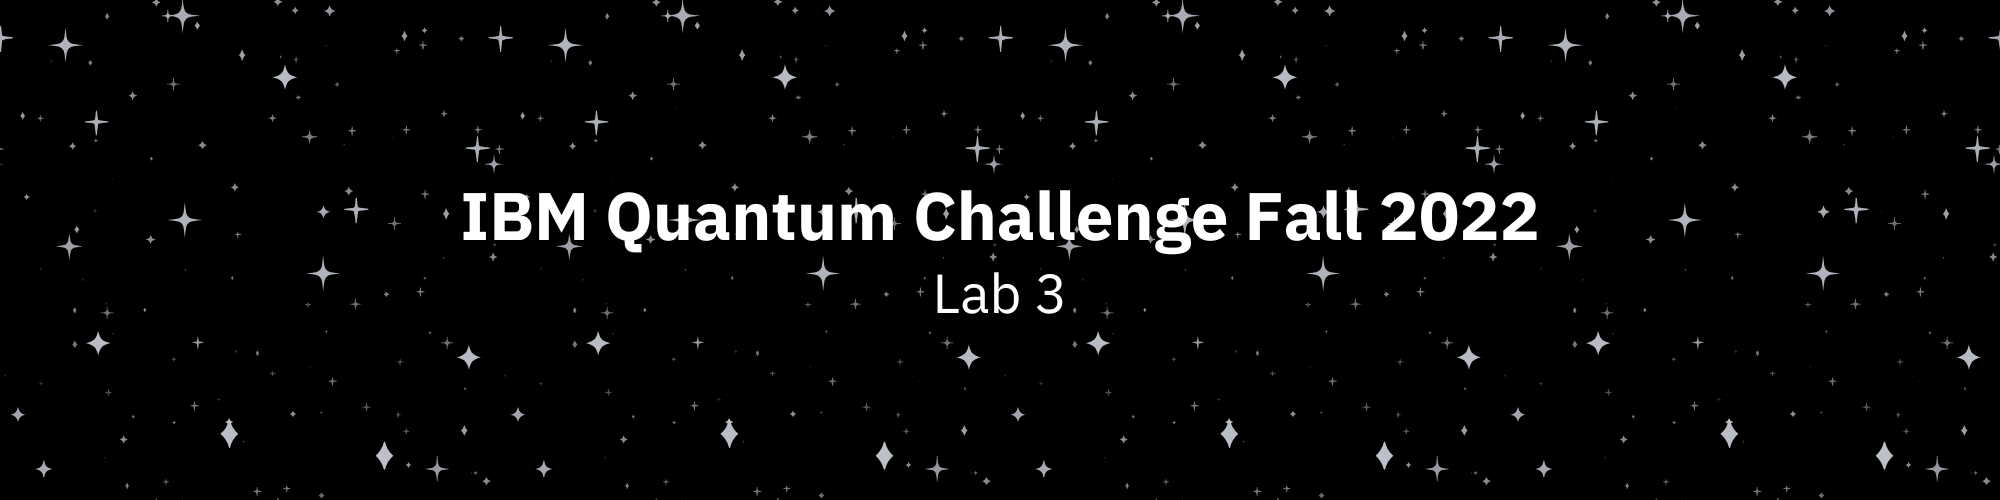

# Quantum Optimization Challenge - Get Your Starship out of a Sticky Situation!

# Table of Contents
- **[Story](#Story---Chapter-3)**
- **[Part I: Formulating the Traveling Salesman Problem](#Part-I:-Formulating-the-Traveling-Salesman-Problem)**
    - **[Exercise 1: create a graph to represent our debris configuration](#exercise1)**
    - **[Exercise 2: convert the problem into a QUBO and obtain the equivalent Ising Hamiltonian](#exercise2)**
- **[Part II: Implementing a Problem Specific Parameterized Quantum Circuit for TSP](#Part-II:-Implementing-a-Problem-Specific-Parameterized-Quantum-Circuit-for-TSP)**
    - **[Exercise 3: construct a 3-qubit W-State with two parameters](#exercise3)**
    - **[Exercise 4: construct a Sampler routine](#exercise4)**
    - **[Exercise 5: build up a TSP entangler routine for a general case](#exercise5)**
    - **[Exercise 6: build up a VQE routine for the TSP entangler](#exercise6)**
    - **[Exercise 7: build up a Sampler routine with the optimal circuit and the list of parameter values](#exercise7)**
    - **[Exercise 8: build up a circuit to accomodate all the constraints](#exercise8)**
    - **[Exercise 9: find a TSP solution for a 4 node graph problem](#exercise9)**

# Story - Chapter 3

With your quantum computers and scanners now working the way they are supposed to, you are ready to identify the optimal planet for your gravity assist maneuver. A well-executed slingshot may just be the key to your escape. 


Your optimization protocol reveals one clear winner: a purple gas giant, with glimmering gaseous swirls and a large spot that reminds you of Jupiter. This planet is much different from what your broken systems would’ve identified if you hadn’t repaired them!

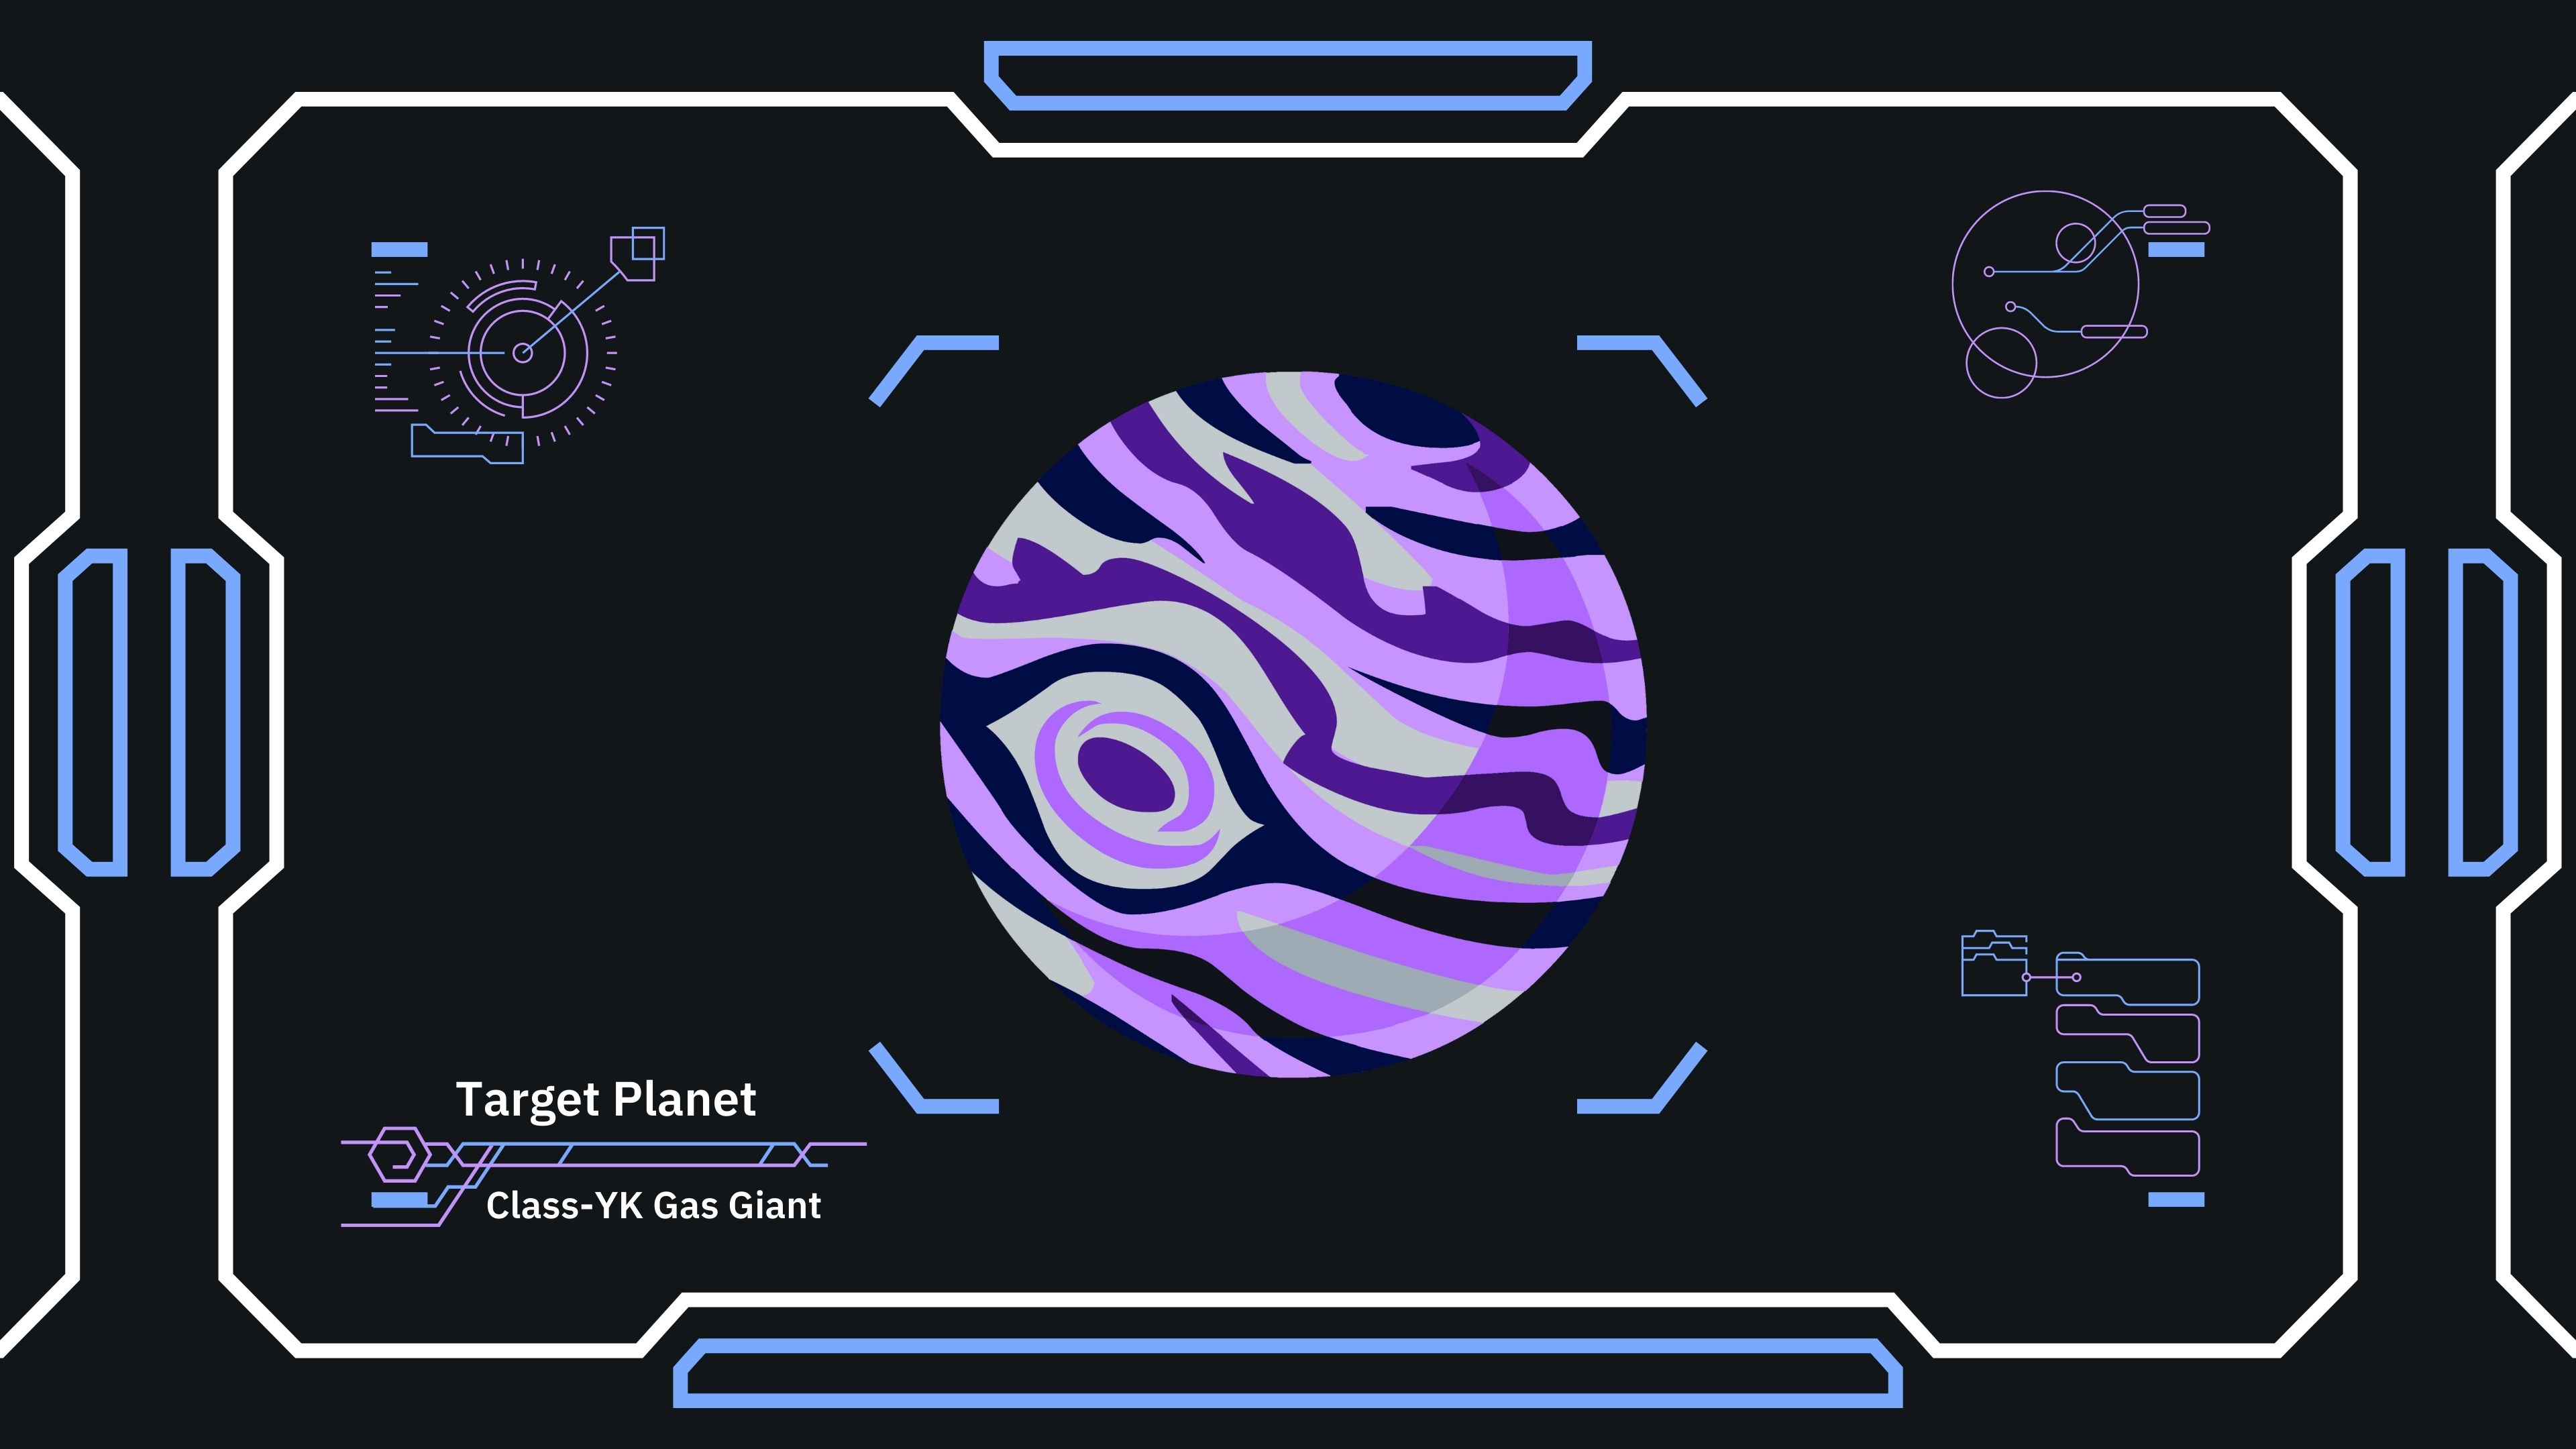

As you prepare your ship for the slingshot, you discover a major obstacle: the region around the planet is rife with space debris. Myriads of objects of varying sizes, some as small as sand grains, some as large as beach balls. Metals and silicates and rocks, remnants of asteroid collisions and perhaps even civilizations long-gone. The objects revolve in an expansive region around the planet.  
 

Your slingshot is at risk: with the debris orbiting at speeds over twenty-five thousand kilometers per hour, a collision could be disastrous. 
 

But, you do not lose hope. You have quantum computers that work, you know quantum optimization, and you have a drone on board that could effectively collect any trash you target. 
 

Complete the exercises below in order to clear an optimal path through the space debris by successfully collecting specific orbiting objects with your drone, thus mitigating the risk associated with the slingshot. 


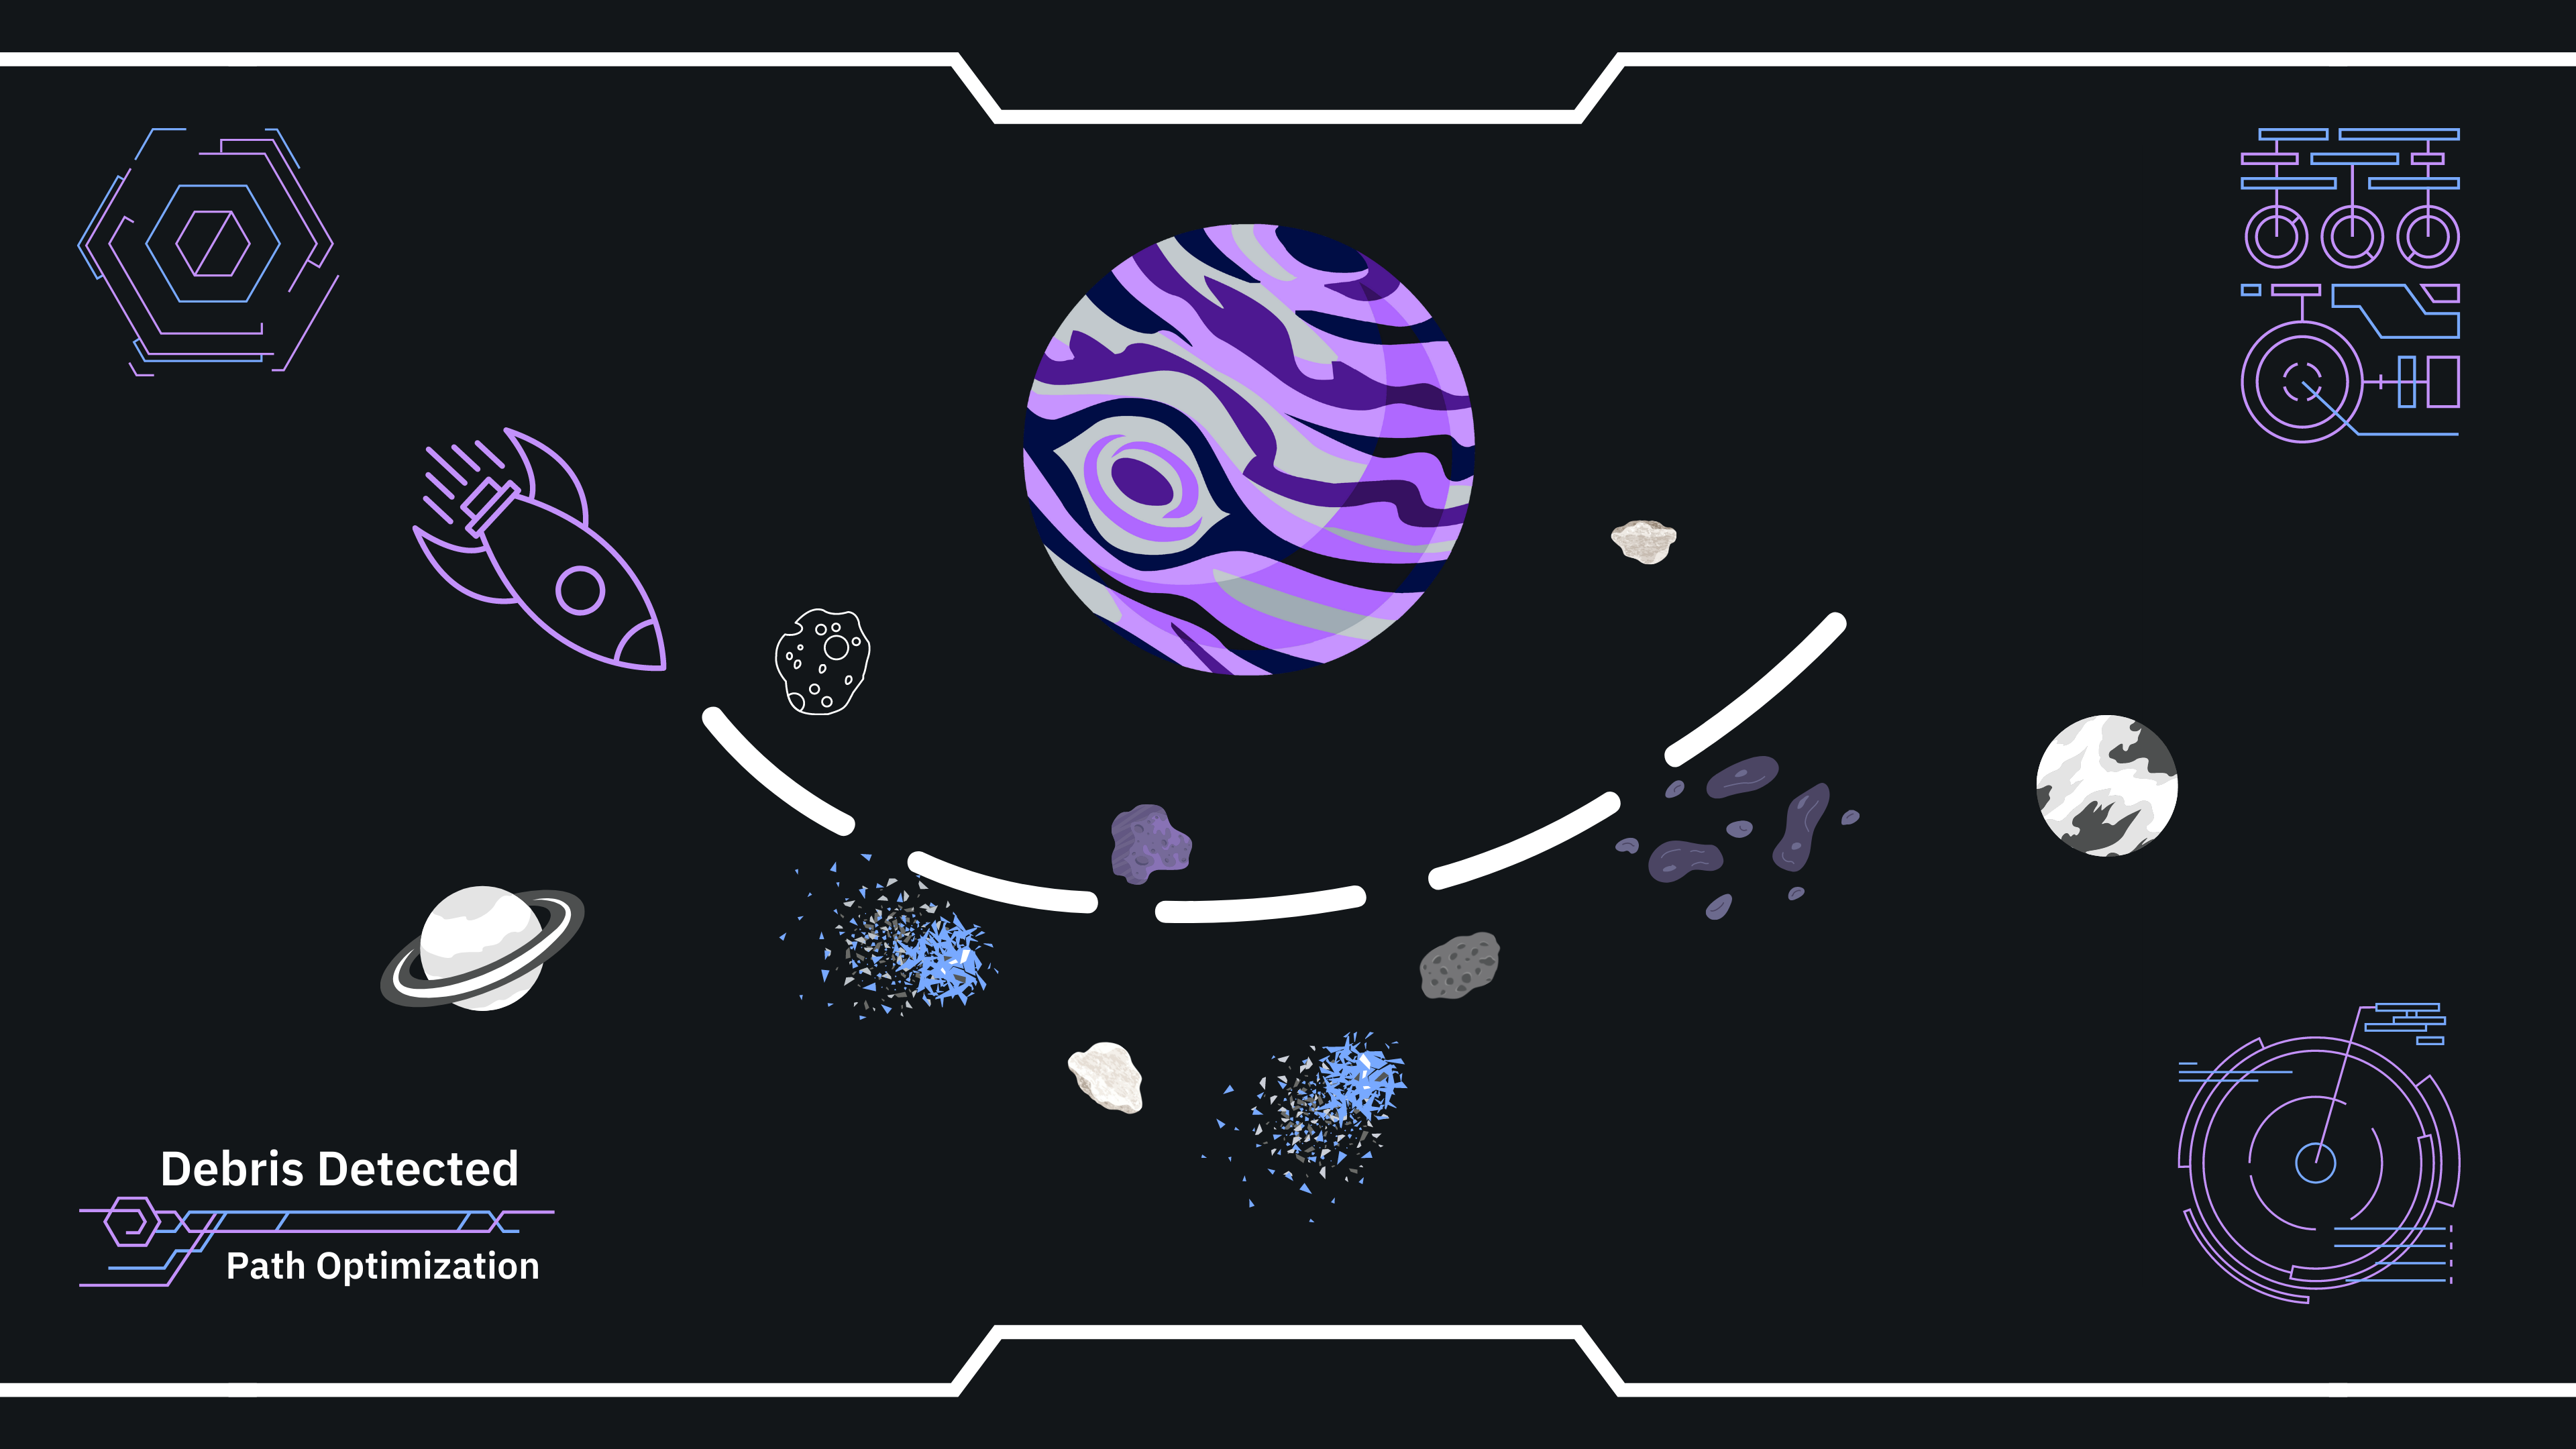

## Introduction to the Traveling Salesman Problem for Collecting Debris through the Shortest Path

To clear our pathway around the planet, we will be sending our drone out to the debris to collect the major pieces; the pieces that would cause catastrophic damage if our starship collided with them. With our scanners now in tip-top shape, we are able to estimate the distances between these large pieces of debris. We cannot risk any time wasted; the black hole is pulling us closer and closer. We need to calculate the optimal pathway for our drone to take in order to collect all pieces of debris in the smallest amount of time (corresponding to the shortest total path for this mission). 

The collection of the debris using the shortest path is essentially a well-known problem called the traveling salesman problem. In addition to being a notorious NP-complete problem that has drawn the attention of computer scientists and mathematicians for over two centuries, the Traveling Salesman Problem (TSP) has important bearings on finance and marketing, as its name suggests. Colloquially speaking, the traveling salesman is a person that goes from city to city to sell merchandise. The objective in this case is to find the shortest path that would enable the salesman to visit all the cities and return to their hometown, i.e. the city where they started traveling. By doing this, the salesman gets to maximize potential sales in the least amount of time. 

# Part I: Formulating the Traveling Salesman Problem

This problem derives its importance from its "hardness" and ubiquitous equivalence to other relevant combinatorial optimization problems that arise in practice.
 
The mathematical formulation with some early analysis was proposed by W.R. Hamilton in the early 19th century. Mathematically the problem is, as in the case of Max-Cut **[[1]](https://learn.qiskit.org/course/ch-applications/solving-combinatorial-optimization-problems-using-qaoa)**, best abstracted in terms of graphs. The TSP on the nodes of a graph asks for the shortest *Hamiltonian cycle* that can be taken through each of the nodes. A Hamilton cycle is a closed path that uses every vertex of a graph once. The general solution is unknown and an algorithm that finds it efficiently (e.g., in polynomial time) is not expected to exist.

Find the shortest Hamiltonian cycle in a graph $G=(V,E)$ with $n=|V|$ nodes and distances, $w_{ij}$ (distance from vertex $i$ to vertex $j$). A Hamiltonian cycle is described by $N^2$ variables $x_{i,p}$, where $i$ represents the node and $p$ represents its order in a prospective cycle. The decision variable takes the value 1 if the solution occurs at node $i$ at time order $p$. We require that every node can only appear once in the cycle, and for each time a node has to occur. This amounts to the two constraints (here and in the following, whenever not specified, the summands run over 0,1,...N-1)

<a id="eq1"></a>
$$
\begin{equation}\tag{1}
\sum_{i} x_{i,p} = 1 ~~\forall p.
\end{equation}
$$

<a id="eq2"></a>
$$
\begin{equation}\tag{2}
\sum_{p} x_{i,p} = 1 ~~\forall i.
\end{equation}
$$

For nodes in our prospective ordering, if $x_{i,p}$ and $x_{j,p+1}$ are both 1, then there should be an energy penalty if $(i,j) \notin E$ (not connected in the graph). The form of this penalty is 

$$\sum_{i,j\notin E}\sum_{p} x_{i,p}x_{j,p+1}>0,$$ 

where it is assumed the boundary condition of the Hamiltonian cycles $(p=N)\equiv (p=0)$. However, here it will be assumed a fully connected graph and not include this term. The distance that needs to be minimized is 

$$C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}.$$

Putting this all together in a single objective function to be minimized, we get the following:

$$C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}+ A\sum_p\left(1- \sum_i x_{i,p}\right)^2+A\sum_i\left(1- \sum_p x_{i,p}\right)^2,$$

where $A$ is a free parameter. One needs to ensure that $A$ is large enough so that these constraints are respected. One way to do this is to choose $A$ such that $A > \mathrm{max}(w_{ij})$.

Once again, it is easy to map the problem in this form to a quantum computer, and the solution will be found by minimizing an Ising Hamiltonian. **[[2]](https://qiskit.org/documentation/optimization/tutorials/06_examples_max_cut_and_tsp.html)**

### Import necessary libraries and packages

In [1]:
from itertools import permutations
import matplotlib.axes as axes
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from typing import Optional

# import all necessary qiskit packages
from qiskit.algorithms import MinimumEigensolver, NumPyMinimumEigensolver, VQE
from qiskit.algorithms.minimum_eigensolvers import QAOA, SamplingVQE
from qiskit.algorithms.optimizers import L_BFGS_B, SLSQP, SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.tools.visualization import plot_histogram
from qiskit.utils import algorithm_globals, QuantumInstance

from qiskit_aer import Aer

from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_optimization.problems import QuadraticProgram

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Create helper functions

In [2]:
# Draw and visualize graph solution
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=900, alpha=0.9, ax=default_axes, pos=pos, node_shape="o")
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

In [3]:
# Compute cost of the obtained result and display result
def TSPCost(energy, result_bitstring, adj_matrix):
    print("-------------------")
    print("Energy:", energy)
    print("Tsp objective:", energy + offset)
    print("Feasibility:", qubo.is_feasible(result_bitstring))
    
    solution_vector = tsp.interpret(result_bitstring)
    print("Solution Vector:", solution_vector)
    print("Solution Objective:", tsp.tsp_value(solution_vector, adj_matrix))
    print("-------------------")
    
    # Draw Graph
    draw_tsp_solution(tsp.graph, solution_vector, colors, pos)

In [4]:
# Plots a convergence graph
def PlotGraph(ideal, mean):
    plt.figure(figsize=(8, 6))
    # Plot label
    for value in range(len(mean)):
        plt.plot(mean[value], label="Proposal {}".format(value+1) )
        
    # Ideal plot
    plt.axhline(y=ideal, color="tab:red", ls="--", label="Target")
    plt.legend(loc="best")
    plt.xlabel("Optimizer iteration")
    plt.ylabel("Energy")
    
    # Plot graph title
    plt.title("TSP Entangler Line {} Constraint".format(len(mean)))
    plt.show()

<a id="exercise1"></a>

<div class="alert alert-block alert-success">
    
<b>Exercise 1:</b> 
    
<b>Create a graph to represent our debris configuration.</b>
    
For this exercise, you have identified **4 significantly large pieces of debris**, your scanners have been able to identify most distances between these pieces of debris, and you have scribbled down the results on a piece of paper. 
    
Use the image below (alternative text is inserted if you are unable to see the image) to generate a graph; the one in your two-dimensional drawing! **Give each node in your graph any color,** for example <span style="color:red"> 'r' </span> for <span style="color:red"> red </span> or <span style="color:blue"> 'b' </span> for <span style="color:blue"> blue</span>. 
    
Feel free to check out the documentation in **[Max-Cut and Traveling Salesman Problem](https://qiskit.org/documentation/optimization/tutorials/06_examples_max_cut_and_tsp.html)** for help on formulating your graph.

This is going to be a very simple exercise just to get you warmed up!
    
</div> 

![Your drawing of the network of debris to clean up. The debris network consists of 4 pieces. Debris 0 is 48 units distance to debris 1, 91 units to debris 2, and 33 units to debris 3. Additionally, debris 1 is 63 units distance to debris 2 and 71 units to debris 3. Finally, debris 3 is 92 units distance to debris 3.](attachment:image.png)
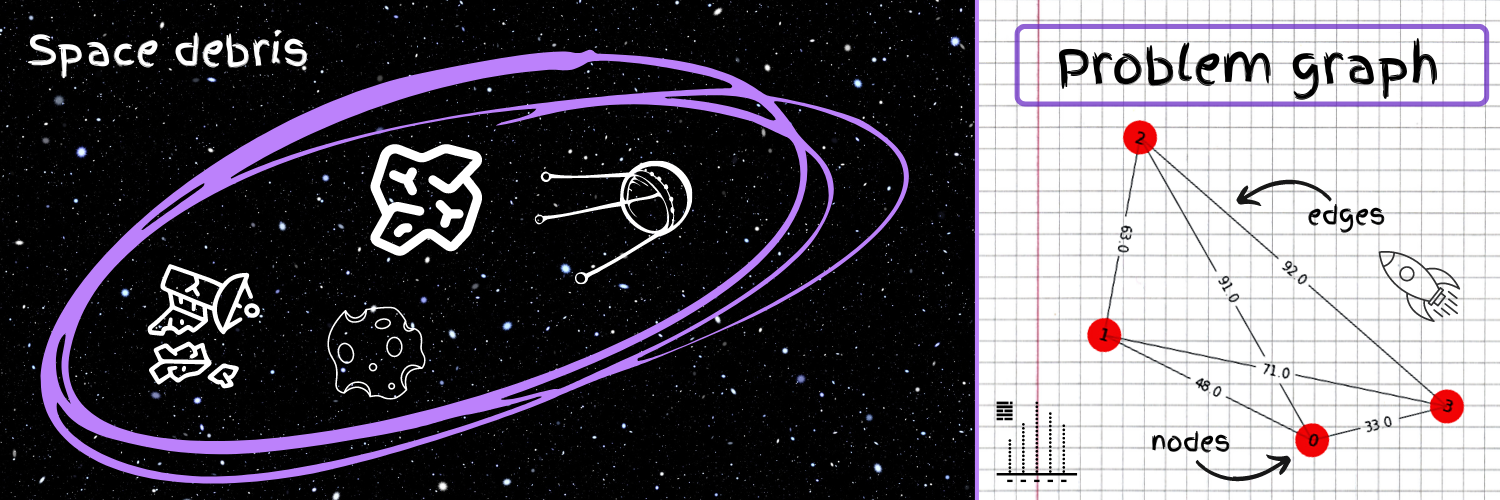

distance
 [[ 0. 48. 91. 33.]
 [48.  0. 63. 71.]
 [91. 63.  0. 92.]
 [33. 71. 92.  0.]]


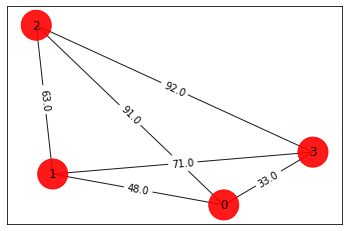

In [5]:
# Let us first generate a graph with 4 nodes!

#### enter your code below ####

n = 4
num_qubits = 4**2

#### enter your code above ####

tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_matrix(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

In [6]:
from qc_grader.challenges.fall_2022 import grade_lab3_ex1

grade_lab3_ex1(n, num_qubits) # Expected result type: int, int

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Great start! You have successfully created a graph that shows the debris location and their distances from one another. 

### Brute force approach

The brute force approach involves trying every combination through classical computation to find the optimal solution. As you can infer, this procedure becomes more computationally-intensive as the number of nodes increases, or as the number of locations the traveling salesman must visit, increases. 

order = (0, 1, 2, 3) Distance = 236.0
Best order from brute force = (0, 1, 2, 3) with total distance = 236.0


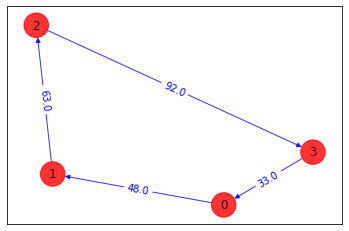

In [7]:
from itertools import permutations


def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


draw_tsp_solution(tsp.graph, best_order, colors, pos)

# Examine the quantum approach

## 1. Call the TSP Application Class and create a Quadratic Program instance
To solve this optimization problem, we first need to convert the TSP problem into a quadratic program, a program which lays out the optimization problem as a quadratic objective function and relevant constraint functions. The TSP defines variables as binary variables, so you will see those defined in the quadratic program as well. 

In [8]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_3 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_3
  + 33*x_0_0*x_3_1 + 33*x_0_0*x_3_3 + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2
  + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2 + 33*x_0_1*x_3_0 + 33*x_0_1*x_3_2
  + 48*x_0_2*x_1_1 + 48*x_0_2*x_1_3 + 91*x_0_2*x_2_1 + 91*x_0_2*x_2_3
  + 33*x_0_2*x_3_1 + 33*x_0_2*x_3_3 + 48*x_0_3*x_1_0 + 48*x_0_3*x_1_2
  + 91*x_0_3*x_2_0 + 91*x_0_3*x_2_2 + 33*x_0_3*x_3_0 + 33*x_0_3*x_3_2
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_3 + 71*x_1_0*x_3_1 + 71*x_1_0*x_3_3
  + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2 + 71*x_1_1*x_3_0 + 71*x_1_1*x_3_2
  + 63*x_1_2*x_2_1 + 63*x_1_2*x_2_3 + 71*x_1_2*x_3_1 + 71*x_1_2*x_3_3
  + 63*x_1_3*x_2_0 + 63*x_1_3*x_2_2 + 71*x_1_3*x_3_0 + 71*x_1_3*x_3_2
  + 92*x_2_0*x_3_1 + 92*x_2_0*x_3_3 + 92*x_2_1*x_3_0 + 92*x_2_1*x_3_2
  + 92*x_2_2*x_3_1 + 92*x_2_2*x_3_3 + 92*x_2_3*x_3_0 + 92*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2

## 2. Convert the quadratic program to QUBO and Ising Hamiltonian
To solve this problem, we need to convert our quadratic program into a form that a quantum computer can work with. In this case we will generate an Ising Hamiltonian, which is simply a representation (i.e. model) of the energy of this particular system (i.e. problem). We can use eigensolvers to find the minimum energy of the Ising hamiltonian, which corresponds to the shortest path and the solution of our problem. 

How do we get the Ising Hamiltonian? First, we convert the quadratic program to a QUBO (Quadratic Unconstrained Binary Optimization), a combinatorial optimization problem representation to then obtain an Ising Hamiltonian. The next exercise will teach you how we do this. 

<a id="exercise2"></a>

<div class="alert alert-block alert-success">
    
<b>Exercise 2:</b>

<b>Convert the quadratic program from above into a QUBO and then obtain the equivalent Ising Hamiltonian.</b>

Check out **[QuadraticProgramToQubo](https://qiskit.org/documentation/optimization/stubs/qiskit_optimization.converters.QuadraticProgramToQubo.html)** and **[Minimum Eigen Optimizer](https://qiskit.org/documentation/optimization/tutorials/03_minimum_eigen_optimizer.html)** for help. 

    
</div> 

In [9]:
from qiskit_optimization.converters import QuadraticProgramToQubo

#### enter your code below ####

qp2qubo = QuadraticProgramToQubo()     #instatiate qp to qubo class
qubo = qp2qubo.convert(qp)             # convert quadratic program to qubo
qubitOp, offset = qubo.to_ising()      #convert qubo to ising

#### enter your code above ####

print("Offset:", offset)
print("Ising Hamiltonian:", str(qubitOp))

Offset: 51756.0
Ising Hamiltonian: -6456.0 * IIIIIIIIIIIIIIIZ
- 6456.0 * IIIIIIIIIIIIIIZI
- 6456.0 * IIIIIIIIIIIIIZII
- 6456.0 * IIIIIIIIIIIIZIII
- 6461.0 * IIIIIIIIIIIZIIII
- 6461.0 * IIIIIIIIIIZIIIII
- 6461.0 * IIIIIIIIIZIIIIII
- 6461.0 * IIIIIIIIZIIIIIII
- 6493.0 * IIIIIIIZIIIIIIII
- 6493.0 * IIIIIIZIIIIIIIII
- 6493.0 * IIIIIZIIIIIIIIII
- 6493.0 * IIIIZIIIIIIIIIII
- 6468.0 * IIIZIIIIIIIIIIII
- 6468.0 * IIZIIIIIIIIIIIII
- 6468.0 * IZIIIIIIIIIIIIII
- 6468.0 * ZIIIIIIIIIIIIIII
+ 1592.5 * IIIIIIIIIIIIIIZZ
+ 1592.5 * IIIIIIIIIIIIIZIZ
+ 1592.5 * IIIIIIIIIIIIIZZI
+ 1592.5 * IIIIIIIIIIIIZIIZ
+ 1592.5 * IIIIIIIIIIIIZIZI
+ 1592.5 * IIIIIIIIIIIIZZII
+ 1592.5 * IIIIIIIIIIIZIIIZ
+ 12.0 * IIIIIIIIIIIZIIZI
+ 12.0 * IIIIIIIIIIIZZIII
+ 12.0 * IIIIIIIIIIZIIIIZ
+ 1592.5 * IIIIIIIIIIZIIIZI
+ 12.0 * IIIIIIIIIIZIIZII
+ 1592.5 * IIIIIIIIIIZZIIII
+ 12.0 * IIIIIIIIIZIIIIZI
+ 1592.5 * IIIIIIIIIZIIIZII
+ 12.0 * IIIIIIIIIZIIZIII
+ 1592.5 * IIIIIIIIIZIZIIII
+ 1592.5 * IIIIIIIIIZZIIIII
+ 12.0 * IIIIIIIIZIIIIIIZ


In [10]:
from qc_grader.challenges.fall_2022 import grade_lab3_ex2

grade_lab3_ex2(qubitOp) # Expected result type: PauliSumOp object

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Good one! 

Let's first attempt to obtain our reference solution by solving our QUBO with an exact classical method, `NumPyMinimumEigensolver`:

### Using NumPyMinimumEigensolver to obtain a reference solution

-------------------
Energy: -51520.0
Tsp objective: 236.0
Feasibility: True
Solution Vector: [1, 2, 3, 0]
Solution Objective: 236.0
-------------------


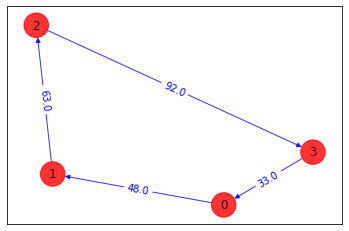

In [11]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

energy_numpy = result.eigenvalue.real
# Call helper function to compute cost of the obtained result and display result
TSPCost(energy = result.eigenvalue.real, result_bitstring = tsp.sample_most_likely(result.eigenstate), adj_matrix = adj_matrix)

## 3. Running it on a quantum computer

Here we are now going to try running the same problem on a quantum computer. 
However, since the calculations for this particular problem can take some time (10 minutes or even longer), we recommend that you take a look at one of the solutions your crew member obtained earlier when running the same problem. We know that time is precious. Especially in a scenario where we have a blackhole to escape from. <br>
<br>This is not a graded exercise so you can take a look at the results and proceed to the next segment of this lab. 

<a id="Error"></a>
<div class="alert alert-block alert-info">
    
## Crew log - VQE Routine Not Converging Well
    
Here is one of the results your crew member obtained when running the same problem earlier. The results can be slightly different from when you run the same problem due to the heuristic nature of the algorithm, but you can see that it is not showing good convergence to the solution. The 'solution objective' (solution of our objective function) gave us '302.0,' which is higher than our reference solution (shortest path) '236.0.' <br>
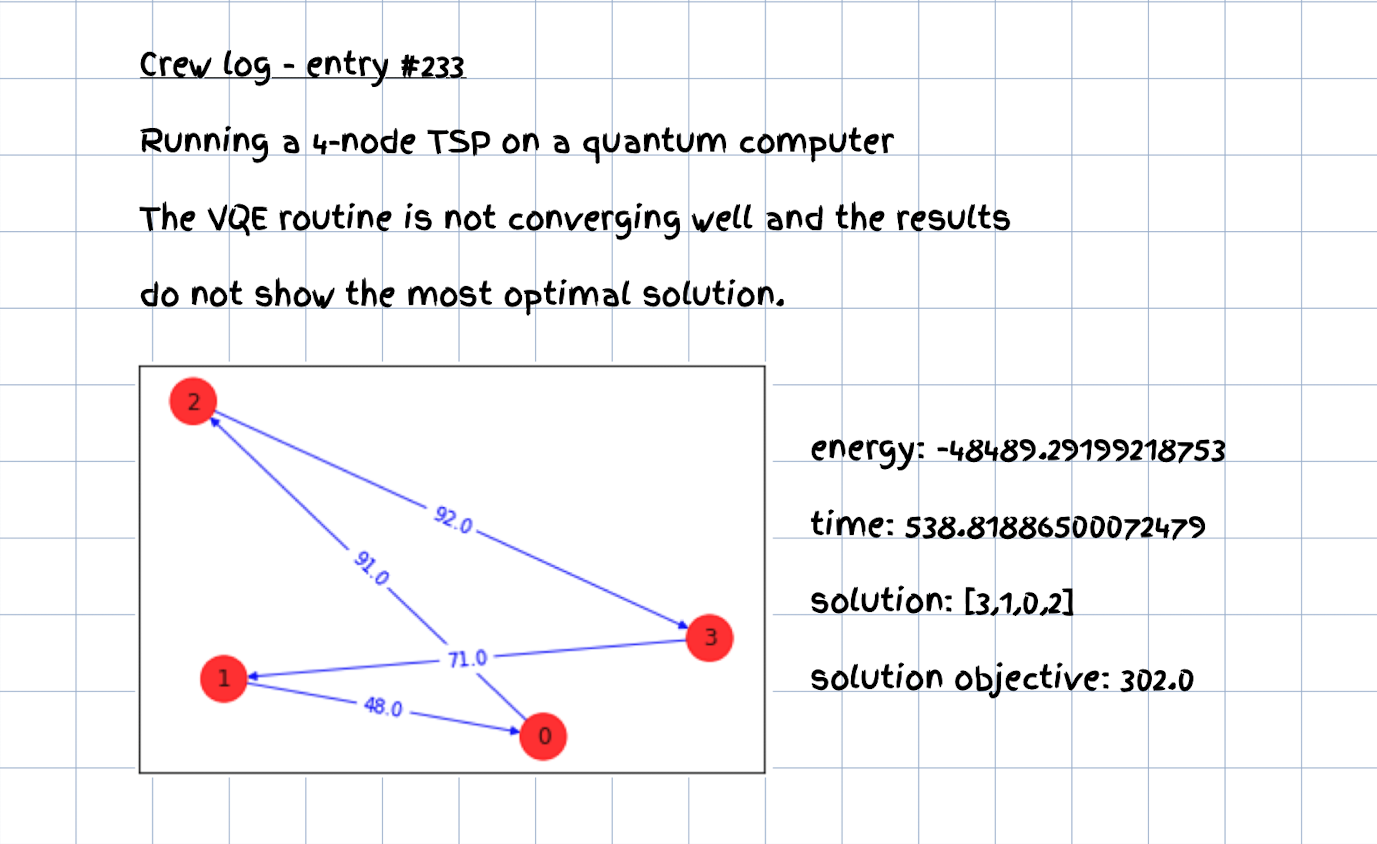

**Note**: Since the cell below will take some time finish running, we recommend that you run this later on your spare time. Luckily, one of your crew members has already run the same problem on a quantum computer earlier and saved the results for you so that you don't have to execute. You may proceed to the next segment.

energy: -48489.29199218753
time: 493.34020018577576
feasible: True
solution: [3, 1, 0, 2]
solution objective: 302.0
solution: [3, 1, 0, 2]
solution objective: 302.0


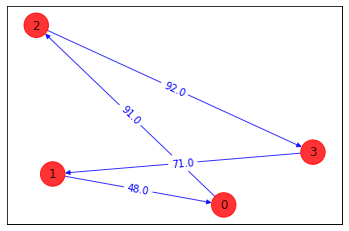

In [12]:
# #This is not a graded exercise. Run this cell when you have spare time. 
# # Let us first specify the backend we will be running 

### Specifying the backend and creating quantum instance
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)


### Building an ansatz with rotational Y gates
# We can use a traditional VQE with an ansatz, which is a trial function selected as an initial guess approximating the minimum eigenstate of a Hamiltonia, built with Y single-qubit rotations and entangler steps.
# Please note that this is heuristic ansatz, which means that it provides you with an educated guess to help solve a problem but does not guarantee to be the most optimal answer.

spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

result = vqe.compute_minimum_eigenvalue(qubitOp)


### Print solution
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

## Heuristic Algorithms

In many applications it is important to find the minimum eigenvalue of a matrix. For example, in chemistry, the minimum eigenvalue of a Hermitian matrix characterizing the molecule is the ground state energy of that system. As we learned earlier, we can map our shortest path problem into an Ising Hamiltonian, which allows us to search for the shortest path in the same way we find the ground state energy of a molecule. 

You may have heard that a quantum state can be represented as a vector in a complex vector space. This space where all the possible quantum states exist is mathematically called a 'Hilbert Space.' As your optimization problem grows in size and the more number of constraints you need to take into consideration, this adds a degree of complexity that will grow your Hilbert Space exponentially.

Problems like the Traveling Salesman Problem are known to be NP-Hard due to how our solution space grows exponentially with each city and constraints added. 

This 'NP-hardness' in theoretical computer science make heuristics the only viable option for a variety of complex optimization problems that need to be routinely solved in real-world applications where the objective of a heuristic approach is to produce a solution in a reasonable time frame that is good enough for solving the problem at hand. This solution may not be the best of all the solutions to this problem, or it may simply approximate the exact solution. But it is still valuable because finding it does not require a prohibitively long time.

You may realize that this indicates that there is a 'trade-off' between optimality and execution time. Some heuristics converge faster than others. How can we get better convergence with our current quantum systems with limited number of qubits? In Part II, we will explore tnis notion by looking at an approach that can help reduce our search space so we can arrive at a good solution in a relatively reasonable amount of time. 

## Need for a problem-specific parameterized quantum circuit (PQC)

The “natural form” of a QUBO model inherently is an unconstrained problem, other than those requiring the variables to be binary (hence the name Quadratic Unconstrained Binary Optimization). Most of the problems that are of interest to mankind tend to include additional constraints in the formulation of the problem to obtain good solutions. Many of these constrained models can be effectively re-formulated as a QUBO model by introducing penalties into the objective function as an alternative to explicitly imposing constraints to best fit the problem construction. **[[3]](https://arxiv.org/pdf/1811.11538.pdf)** 

We can utilize the constraints of our TSP problem to dynamically construct a problem-specific PQC that reflects those constraints of the optimization problem. Therefore, we can restrict a unitary transformation that is provided by the problem-specific PQC while taking constraints into account. This makes it possible to make the search space smaller in hopes of arriving at an optimal or near-optimal solution!

# Part II: Implementing a Problem Specific Parameterized Quantum Circuit for TSP

As mentioned above, we shall be looking at implementing a problem specific PQC for our TSP problem to attempt to reduce our search space and arrive at a good solution. This is an active area of interest and there are multiple PQC approaches for the TSP problem, however specifically, we shall be looking at one of the implementations by **[Matsuo, A., Suzuki, Y., & Yamashita, S. Problem-specific parameterized quantum circuits of the VQE algorithm for optimization problems. 2020.](https://arxiv.org/pdf/2006.05643.pdf)** **[[4]](https://arxiv.org/pdf/2006.05643.pdf)**

One of the reasons of intractability for many problems comes from the huge search space that exists for a solution. With so many possibilities to evaluate, a brute force search approach quickly becomes computationally unfeasible. The idea here is to reduce the subspace in such a way that it still includes the solution subspace, but is significantly smaller than the complete subspace, lets call it $|S_{all}|$. So the main objective is to propose a PQC that gives us a subspace: $S_{proposed}$ that includes $S_{feasible\_solutions}$, but such that the size of $S_{proposed}$ subspace is smaller than $|S_{all}|$. This increases the possibility of arriving at optimal or near optimal solution while reducing the required time to find the same as compared to, let's say, using a heuristic approach on the whole subspace!



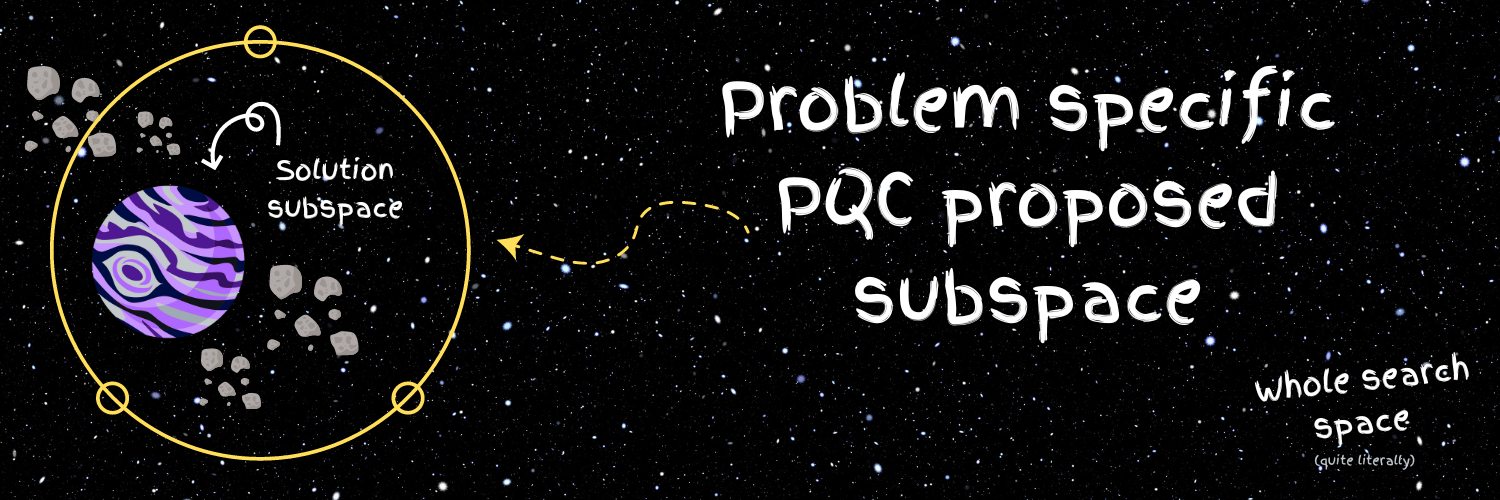

Usually, an optimization problem can have more than one constraint. For such cases, we create multiple problem-specific parameterized quantum sub-circuits, each of which reflect the corresponding constraint. Then, by
combining those sub-circuits properly, even though the optimization problem has more than one constraint, it is
still possible to **create a problem-specific PQC and reduce the search space**.

The paper we mentioned above proposes **4 different types of PQCs** approaching the problem in different ways, each with different characteristics and constraints considered. For the NISQ era, characteristics of a circuit such as number of gates, parameters, entanglement and circuit depth are important factors when designing PQCs and here we shall be looking into a few of the approaches as showcased in the paper above. We will be utilizing the **VQE algorithm** to build upon the routine to get our results using the **Estimator and Sampler primitive!**

## PQCs satisfying only the constraints on the first line **[Eq. (1)](#eq1)**

Let's check out the first type of problem-specific PQC as proposed for our TSP problem here to effectively collect our space debris. The paper proposes us to take into account only the constraints in the first line as shown below:  

$$\sum_{i}^{N} x_{i,p} = 1 ~~\forall p = 1...N.$$
  
As we can see, in each of the constraints, exactly one of the variables has to be one while the other variables have to be zero. This type of constraint restricts the set of solutions to the **set of bases corresponding to the $W$ state**.

A $W$ state is a superposition of states where exactly one of the qubits is $|1\rangle$ while all other qubits are $|0\rangle$ with equal amplitudes. A $W$ state for $n$ qubits is represented as $|W\rangle = \frac{1}{\sqrt{2^n}} (|10...0\rangle + |01...0\rangle + |00...1\rangle)$. Each of the bases of this state corresponds to the constraint as mentioned above  $\sum{x_i} = 1$.  Since the other bases do not satisfy the constraint of $\sum{x_i} = 1$, we do not consider them here hence reducing our subspace for solving the problem with considerations of the constraints from the equation in the first line. We shall create circuits representing the $W$ state in such a way that we can control the amplitudes of each base.


$$|W(φ)\rangle = \sum_{i} α_{i(φ)}|ψ_i\rangle, $$
$$\sum_{i} {|α_{i(φ)}|}^2 = 1,   $$
$$|ψ_i\rangle ∈ \{{|10...0\rangle, |01...0\rangle, |00...1\rangle}\}$$


Let us see how we can do that for a 3 qubit example. Construct the W state for a 3 qubit circuit below!

<a id="exercise1"></a>

<div class="alert alert-block alert-info">
    
<b>Note with regards to graph for Exercises 3-8 </b>

We will be learning on these approaches using a smaller **3 Node graph** as described below. We shall get an intuition of these approaches using a smaller graph and then extrapolate for a larger graph. **We shall be solving the problem for a 4 Node graph in Exercise 9.** Onto Exercise 3 now! 
    
</div> 

Learning problem 3 Node graph: 
Ideal energy: -4751.0


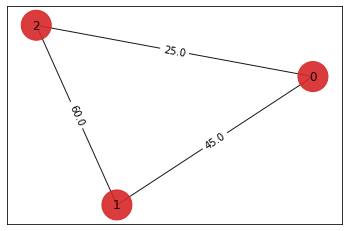

In [13]:
# Define 3 Node graph for our learning exercises
n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=250)

adj_matrix = nx.to_numpy_matrix(tsp.graph)

# Plot graph
colors = ["tab:red" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]

print("Learning problem 3 Node graph: ")
draw_graph(tsp.graph, colors, pos)

# Define quadratic program for 4 node graph
qp = tsp.to_quadratic_program()

# Define Ising operator for 3 Node graph
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()

# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

# Ideal result
ideal = result.eigenvalue.real
print(f"Ideal energy: {ideal}")

<a id="exercise3"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 3:</b> 
    
<b>Construct a 3-qubit W-State as mentioned above with two parameters.</b>
Feel free to navigate to **section 3.2.1** in the paper to see how a 3 qubit W state can be implemented. The paper for the same is linked here: **[Matsuo, A., Suzuki, Y., & Yamashita, S. (2020). Problem-specific parameterized quantum circuits of the VQE algorithm for optimization problems. arXiv preprint arXiv:2006.05643.](https://arxiv.org/pdf/2006.05643.pdf)** </div> 

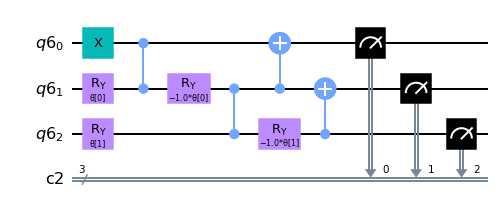

In [14]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector, QuantumCircuit

# Initialize circuit
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
circuit = QuantumCircuit(qr,cr)

# Initialize Parameter with θ
theta = ParameterVector('θ', 2)

#### enter your code below ####

# Apply gates to circuit
circuit.x(0)
for i in range(2):
    circuit.ry(theta[i], i+1)
    circuit.cz(i,i+1)
    circuit.ry(-theta[i], i+1)
for i in range(2):
    circuit.cx(i+1,i)

#### enter your code above ####

circuit.measure(qr,cr)
circuit.draw("mpl")

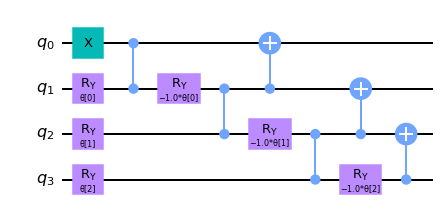

In [15]:
# Generalising the above so it can used repeatedly below
def w_state(n):
    """Quantum circuit to prepare a n-qubit W-State"""
    circuit = QuantumCircuit(n, name=f"{n}q W-State")
    theta = ParameterVector('θ', n-1)
    
    circuit.x(0)
    for i in range(n-1):
        circuit.ry(theta[i], i+1)
        circuit.cz(i,i+1)
        circuit.ry(-theta[i], i+1)
    for i in range(n-1):
        circuit.cx(i+1,i)
    
    return circuit

w_state(4).draw(output="mpl")

In [16]:
from qc_grader.challenges.fall_2022 import grade_lab3_ex3

grade_lab3_ex3(circuit) # Expected result type: QuantumCircuit object

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Running it on the Sampler primitive
Now its time to run the circuit with some parameters and observe the quasi-probability distribution! As per the paper we should be seeing the probability distribution being controlled as per the equation (11) in **section 3.2.1** **[in the paper](https://arxiv.org/pdf/2006.05643.pdf)**.

$$α_{1(φ)} |100\rangle + α_{2(φ)} |010\rangle + α_{3(φ)} |001\rangle,$$
$$\sum_{i}^3 {|α_{i(φ)}|}^2 = 1, $$
$$α_{1(φ)} = cos(\theta_1), α_{2(φ)} = -sin(\theta_1) cos(\theta_2), α_{3(φ)} = sin(\theta_1) sin(\theta_2)$$

For an example's sake, let's try to get an equal distribution for the 3 qubit state. That would mean we should be seeing equal/near equal distributions for the states $|100\rangle, |010\rangle, |001\rangle$ i.e. decimal states $1, 2 $ and  $4$ if we satisfy the equation above to have $α_{1(φ)} = α_{2(φ)} = α_{3(φ)}$

Let us visualize and confirm this result! According to the equation above, solving it to see a near equal probability across the three states of 1, 2 and 4, we can enter in $\theta_1$ as 54.73 degrees and $\theta_2$ as 45 degrees!

<a id="exercise4"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 4:</b> 
    
<b>Construct a Sampler routine to run the circuit you just built above!</b>
Use the sampler.run method to run the circuit and get a quasi-probability distribution out. As per our example above, **use parameters $\theta_1$ as 54.73 degrees and $\theta_2$ as 45 degrees** for the parameters respectively and set the **shots to 5000** in the run method. Remember that for parameters in quantum circuits, angles are defined as radian units (360 degrees = 2$\pi$). Also pass in the options parameter in your Sampler call for the seed to be enforced. </div>

In [17]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Initialize service and backend
#QiskitRuntimeService.save_account(channel='ibm_quantum', token='my_token', overwrite=True) #uncomment if you need to save your account again
service = QiskitRuntimeService(channel="ibm_quantum")

# Set simulator
backend = service.backends(simulator=True)[0]
print(backend)

<IBMBackend('ibmq_qasm_simulator')>


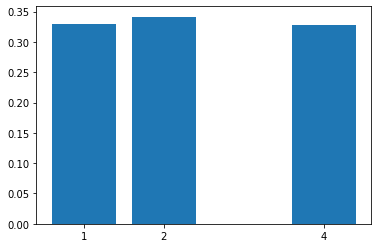

{1: 0.3298, 4: 0.3286, 2: 0.3416}


In [18]:
from math import pi
from qiskit_ibm_runtime import Session, Sampler, Options

options = Options(simulator={"seed_simulator": 42},resilience_level=0) #DO NOT CHANGE

#### Enter your code below ####

# Define sampler object
with Session(service=service, backend=backend):
    sampler = Sampler(options=options) # Define sampler with options above
    bound_circ = circuit.bind_parameters((54.73/180*np.pi, 45/180*np.pi))
    result = sampler.run(bound_circ, shots=5000).result() # Run the sampler. Remember, the theta here is in degrees! :) 

# Plot result 
result_dict = result.quasi_dists[0] # Obtain the quasi distribution. Note: Expected result type: QuasiDistribution dict

#### Enter your code above ####

values = list(result_dict.keys()) # Obtain all the values in a list
probabilities = list(result_dict.values()) # Obtain all the probabilities in a list

plt.bar(values,probabilities,tick_label=values)
plt.show()
print(result_dict)

In [19]:
from qc_grader.challenges.fall_2022 import grade_lab3_ex4

grade_lab3_ex4(result_dict)  # Expected result type: QuasiDistribution dict

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


You may not see an exact distribution due to the randomness added by the simulator and the less precise theta value used here. But nonetheless, we have achieved our intended example objective! Feel free to play around with the theta values and as far as the thetas conform to the equation constraints we mentioned above, you should be seeing amplitude changes corresponding to only the states we mentioned above!

Now let's proceed to apply this to an algorithm and see how we can use this state for our problem as per the paper!

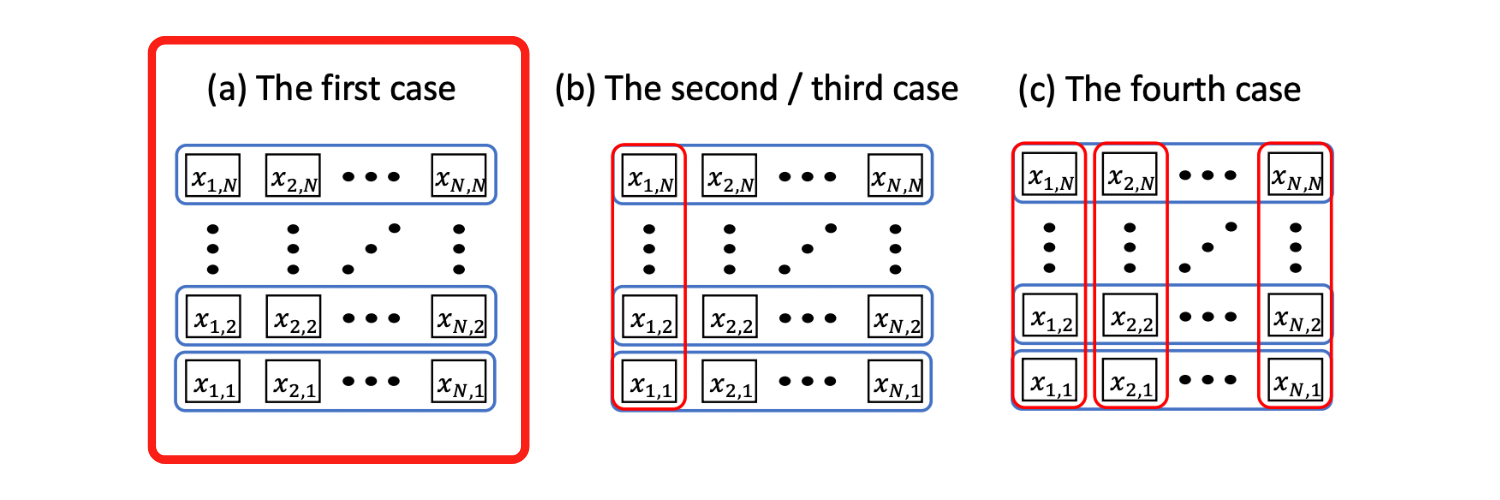

Image credits: **[Matsuo, A., Suzuki, Y., & Yamashita, S. (2020). Problem-specific parameterized quantum circuits of the VQE algorithm for optimization problems. arXiv preprint arXiv:2006.05643.](https://arxiv.org/pdf/2006.05643.pdf)**

We will now proceed to build the routine as suggested above. For a TSP problem, the problem is encoded for an $N$ node graph is encoded in $N^2$ qubits. We need to append the W gate routine in this order for the PQC to be applied successfully as per our problem constraint. We will first look at a case for a 2 node graph and then proceed to have a **generalized function to generate the W state for any arbitrary value of N.**

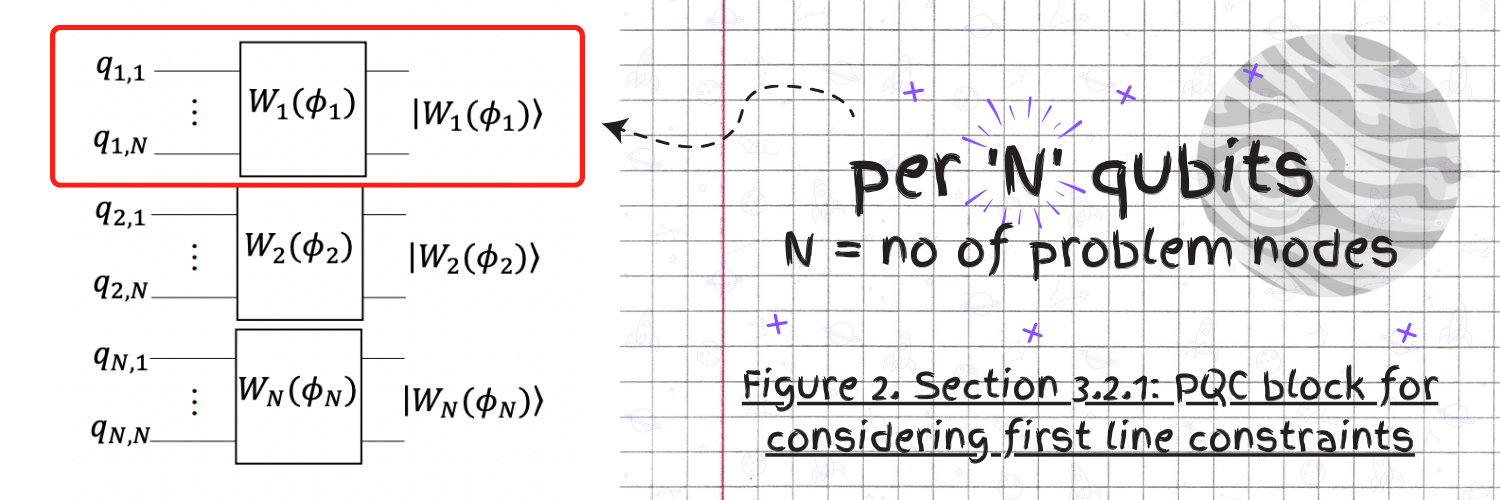

For an example here, let us consider this condition for a 2 node graph. For a 2 node graph, we would require 4 qubits. **Note, here we shall follow the row-major order.** The first two qubits would represent the columns of the first row respectively as shown in the figure and the last 2 qubits would represent the columns in the $N^{th}$ row which in this case are the two elements in the second row. The number of parameters we require in general would be $(N)*(N-1)$. Let's check out how to apply this TSP entangler routine for a 2 node graph and extrapolate this for the general solution as an exercise.

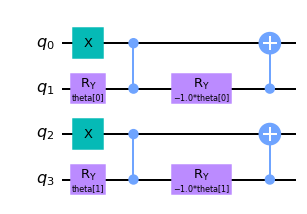

In [20]:
# Two Node TSP entangler
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector, QuantumCircuit

# Set value of N
N = 2

# Define Circuit and ParameterVector
circuit = QuantumCircuit(N**2)
theta =  ParameterVector('theta',length=(N-1)*N)

# Block 1 ----------------
# X Gate -----------------
circuit.x(0)
# Parameter Gates --------
circuit.ry(theta[0],1)
circuit.cz(0,1)
circuit.ry(-theta[0],1)
# CX gates ---------------
circuit.cx(1,0)

# Block 2 ----------------
# X Gate -----------------
circuit.x(2)
# Parameter Gates --------
circuit.ry(theta[1],3)
circuit.cz(2,3)
circuit.ry(-theta[1],3)
# CX gates ---------------
circuit.cx(3,2)

circuit.draw("mpl")

For a graph with $N = 3$, we will be following the same. The circuit you made in Exercise 3 will be the one that will be applied 3 times as a block. In general, you will have the W state applied for N qubits as one block. In total, there will be N blocks across $N^2$ qubits to complete the problem.

In the next exercise, we shall **build up a TSP entangler routine** for the above shown constraint **for any general N qubit case.** Pass the function to the grader to complete this exercise.

<a id="exercise5"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 5:</b> 
    
<b>Build up a TSP entangler routine as described in the paper for a general N qubit case</b>. Complete the function by filling in the blank sections below which takes in an **input N** for the number of nodes of the graph and **returns a QuantumCircuit** with the entangling routine as described previously. **Pass this function to the grader to complete the exercise.**
    
We shall use this to run our VQE routine and compute the solution for the graph we made in the first half of the notebook in the next exercise!  </div> 

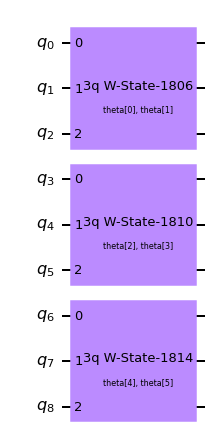

In [21]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector, QuantumCircuit

def tsp_entangler(N):
    
    # Define QuantumCircuit and ParameterVector size
    circuit = QuantumCircuit(N**2)
    theta =  ParameterVector('theta',length=(N-1)*N)
    
    ############# 
    # Hint: One of the approaches that you can go for is having an outer `for` loop for each node and 2 inner loops for each block. /
    # Continue on by applying the same routine as we did above for each node with inner `for` loops for /
    # the ry-cz-ry routine and cx gates. Selecting which indices to apply for the routine will be the /
    # key thing to solve here. The indices will depend on which parameter index you are checking for and the current node! /
    # Reference solution has one outer loop for nodes and one inner loop each for rz-cz-ry and cx gates respectively.
    ############# 
    
    #### enter your code below ####
    
    for i in range(N):
        sub_circ = w_state(N).assign_parameters(theta[i*(N-1):(i+1)*(N-1)])
        circuit.append(sub_circ, range(i*N, (i+1)*N))
        
    #### enter your code above ####

    return circuit

tsp_entangler(3).draw(output="mpl")

In [22]:
from qc_grader.challenges.fall_2022 import grade_lab3_ex5

grade_lab3_ex5(tsp_entangler)  # Expected result type: function

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Great job! We now have the building blocks to run our PQC and test our solution! Let's start constructing the VQE function for calculating our best result for the problem. We shall be using the **[VQE](#insert-doc-link-when-available) class** to build up our VQE routine and calculate the result **using the Estimator Primitive**.

### Solving the problem using the VQE class 

The `VQE` class in Qiskit is now refactored to leverage the Quantum primitive construct. It uses a variational technique to find the minimum eigenvalue of a given diagonal operator but is executed using the `Estimator` primitive. 

An instance of `VQE` also requires an ansatz, a parameterized QuantumCircuit, to prepare the trial state $|\psi(\vec\theta)\rangle$. It also needs a classical optimizer which varies the circuit parameters $\vec\theta$ such that the expectation value of the operator on the corresponding state approaches a minimum. In this case we are interested in extracting the result bitstring corresponding to the optimal solution from the converged result.

These are the following values it takes as per the **[Qiskit Documentation](https://qiskit.org/documentation/stubs/qiskit.algorithms.minimum_eigensolvers.VQE.html#qiskit.algorithms.minimum_eigensolvers.VQE)**:
  
>Arguments:
>- `estimator`: The estimator primitive to compute the expectation value of the Hamiltonian operator.
>- `ansatz`: A parameterized quantum circuit to prepare the trial state.  
>- `optimizer`: A classical optimizer to find the minimum energy. This can either be a Qiskit.Optimizer or a callable implementing the .Minimizer protocol. 
>- `initial_point`: An optional initial point (i.e. initial parameter values) for the optimizer. The length of the initial point must match the number of ansatz parameters. If None, a random point will be generated within certain parameter bounds. SamplingVQE will look to the ansatz for these bounds. If the ansatz does not specify bounds, bounds of -2\pi, 2\pi will be used.  
>- `callback`: A callback that can access the intermediate data at each optimization step. These data are: the evaluation count, the optimizer parameters for the ansatz, the estimated value, and the metadata dictionary.

<a id="exercise6"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 6:</b> 
    
<b>Build up a VQE routine for the TSP entangler you made in Exercise 5.</b> Complete the code block below using the comments as guidelines. You can also checkout the VQE documentation **[here](https://qiskit.org/documentation/stubs/qiskit.algorithms.minimum_eigensolvers.VQE.html#qiskit.algorithms.minimum_eigensolvers.VQE)**. **Pass the result obtained to the grader to complete the exercise.** Please keep the seed values constant for the grading to be successful.
    
We shall use this routine to build a general VQE function next and explore the next PQC as explained in the paper!  </div> 

<a id="exercise6"></a>
<div class="alert alert-block alert-danger">
    
<b>Note on execution times:</b>   
    
The VQE cells may take up to 10-15 minutes to run based on your location. Here we will be passing in jobs to the simulator on cloud time here is due to each job taking about ~1 second to run including network latency of passing the jobs and the result back to the optimizer. Feel free to check out `Program jobs` on the IQX portal to see if your jobs are running: **https://quantum-computing.ibm.com/jobs?jobs=runtime**.

In [23]:
# Imports
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms.minimum_eigen_solvers import NumPyMinimumEigensolver,  MinimumEigensolver
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, VQE
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SPSA, SLSQP, L_BFGS_B
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
import numpy as np

In [24]:
# Define PQC for 3 node graph (Hint: Call the previous function you just made)
PQC = tsp_entangler(3)

In [25]:
def RunVQE(estimator, model, optimizer, operator, init=None):
    
    # Store intermediate results
    history = {"eval_count": [], "parameters": [], "mean": [], "metadata": []}
    
    # Define callback function
    def store_intermediate_result(eval_count, parameters, mean, metadata):
        history["eval_count"].append(eval_count)
        history["parameters"].append(parameters)
        history["mean"].append(mean.real)
            
    #### Enter your code below ####
    
    # Define VQE run
    vqe = VQE(estimator, model, optimizer, initial_point=init, 
              callback=store_intermediate_result)

    # Compute minimum_eigenvalue
    result = vqe.compute_minimum_eigenvalue(operator)
    
    #### Enter your code above ####

    return result, history["mean"]

#### Running the routine and checking our result for the first PQC for 3 qubit case:

In [26]:
%%time
# Do not change the code below and use the given seeds for successful grading
from qiskit.utils import algorithm_globals
from qiskit.primitives import Estimator
algorithm_globals.random_seed = 123

# Define optimizer
optimizer = SPSA(maxiter=50)

# Define Initial point
np.random.seed(10)
init = np.random.rand((n-1)*n) * 2 * np.pi

# Define backend
backend = service.backends(simulator=True)[0]

#### Enter your code below ####

# Call RunVQE. Do not pass in options
with Session(service = service, backend = backend):
    result, mean = RunVQE(Estimator(), PQC, optimizer, qubitOp, init)

#### Enter your code above ####

# Print result
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 100,
    'eigenvalue': -4750.85369976058,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa89fd71ee0>,
    'optimal_parameters': {   ParameterVectorElement(theta[0]): 3.1405938762891474,
                              ParameterVectorElement(theta[1]): -1.660067101003188,
                              ParameterVectorElement(theta[5]): 3.147716694624536,
                              ParameterVectorElement(theta[3]): 4.70869194010299,
                              ParameterVectorElement(theta[4]): 4.706895428144666,
                              ParameterVectorElement(theta[2]): 4.708620211338824},
    'optimal_point': array([ 3.14059388, -1.6600671 ,  4.70862021,  4.70869194,  4.70689543,
        3.14771669]),
    'optimal_value': -4750.85369976058,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7fa8a02ecf40>,
    'op

<a id="Error"></a>
<div class="alert alert-block alert-info">
    
<b>Note on:  `AttributeError: 'Nonetype' object has no attribute values` :</b>   
    
When the cell is initially run, you may encounter this error message. If this is the case, please run the cell once again to ensure a successful convergence.

In [27]:
from qc_grader.challenges.fall_2022 import grade_lab3_ex6

grade_lab3_ex6(result) # Expected result type: VQEResult object

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Computing the Eigenstate from the VQEResult object

Next here, we shall proceed to **compute the Eigenstate of our solution** and get our **best distribution binary string** from the `VQEResult` object. To obtain the eigenstate, we shall sample the parametrized ansatz with the optimal parameters that we obtained by running the `Estimator` call on our VQE function. We shall use the `Sampler` here to sample our ansatz with the `optimal_parameters` from the `VQEResult` object. The key corresponding to the maximum of the `nearest_probability_distribution`  we obtain will be our binary state of the best solution which we will pass on to evaluate!

Let's setup our `Sampler` routine for the same. First, we will extract the `optimal_circuit` from our computed result and apply measurements for the `Sampler` routine. Here we use `inplace=False` to make sure we store the circuit with measurements as a new circuit.

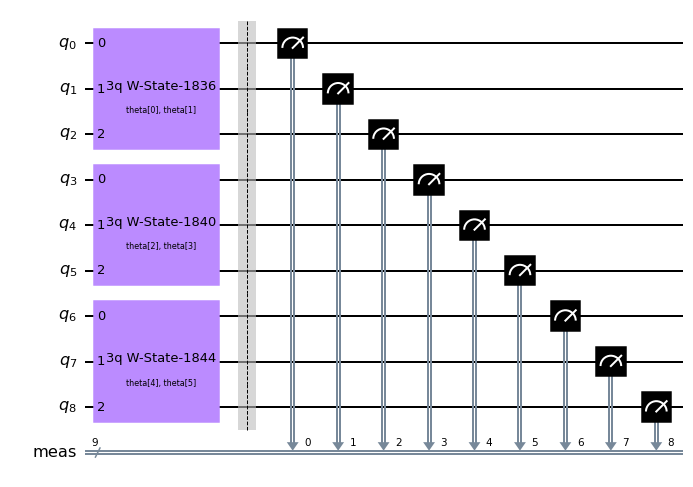

In [28]:
optimal = result.optimal_circuit.measure_all(inplace=False) # Extract optimal circuit and add measurements
optimal.draw("mpl")

### Setting up Sampler to obtain our best bitstring

Next, let us proceed to setup our Sampler to obtain the best bitstring from the result we just computed. Here we shall pass the optimal circuit with the measurements as computed above and extract the optimal_parameters list from result.

>A note on the usage of nearest_probability_distribution: While a Quasiprobability distribution does offer a wider gamut of information data points at your disposal, we cannot directly substitute it for a real probability distribution. For a Quasiprobability distribution to be converted into a true probability distribution, we shall use here the `nearest_probability_distribution()` function. This function takes a quasiprobability distribution as an input and maps it to the closest probability distribution as defined by the L2-norm up to a certain error bound

We shall now use this to get our eigenstate and obtain the optimal result from this distribution!

<a id="exercise7"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 7:</b> 
    
Build up a Sampler routine and pass in the optimal circuit and the list of parameter values obtained from the VQE result we computed previously. Obtain the nearest probability distribution from the sampler result you just obtained. **Please keep the seed values constant for the grading to be successful.**
    
We shall use this value to compute the feasibility of our solution in the next cells.  

In [29]:
def BestBitstring(result, optimal_circuit):
    energy = result.eigenvalue.real
    
    options = Options(simulator={"seed_simulator": 42},resilience_level=0) # Do not change and please pass it in the Sampler call for successful grading
    
    #### enter your code below ####
    with Session(service = service, backend = backend):
        sampler_result = Sampler(options=options).run(circuits=[optimal_circuit,],
                         parameter_values=[list(result.optimal_parameters.values()),]).result() # Enter your code here. Please do pass in options in the Sampler construct.
    result_prob_dist = sampler_result.quasi_dists[0].nearest_probability_distribution() # Obtain the nearest_probability_distribution for the sampler result from the quasi distribution obtained
   
    #### enter your code above ####
    
    max_key = format(max(result_prob_dist, key = result_prob_dist.get),"016b")

    result_bitstring = np.array(list(map(int, max_key)))
    
    return energy, sampler_result, result_prob_dist, result_bitstring

In [30]:
%%time
# Compute values
with Session(service=service, backend=backend):
    energy, sampler_result, result_prob_dist, result_bitstring = BestBitstring(result=result, optimal_circuit=optimal)
print("Optimal bitstring = ", result_bitstring[7:])

Optimal bitstring =  [0 1 0 1 0 0 0 0 1]
CPU times: user 26.4 ms, sys: 3.99 ms, total: 30.4 ms
Wall time: 1.28 s


In [31]:
from qc_grader.challenges.fall_2022 import grade_lab3_ex7

grade_lab3_ex7(sampler_result, result_prob_dist) # Expected result type - sampler_result: SamplerResult, result_prob_dist: ProbDistribution

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


-------------------
Energy: -4750.85369976058
Tsp objective: 130.14630023942027
Feasibility: True
Solution Vector: [1, 0, 2]
Solution Objective: 130.0
-------------------


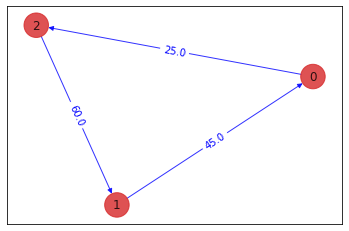

In [32]:
# Compute cost of the obtained result and display result
TSPCost(energy = energy, result_bitstring = result_bitstring[7:], adj_matrix = adj_matrix)

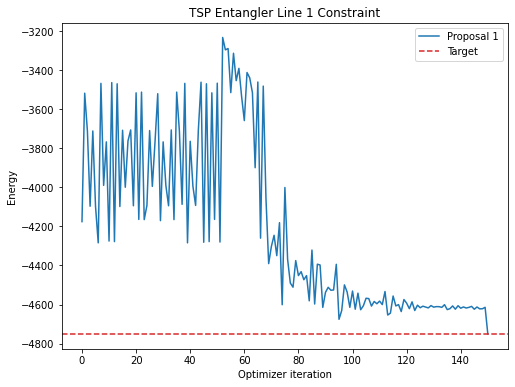

In [33]:
# Plot convergence
PlotGraph(ideal = ideal, mean = [mean])

## PQCs satisfying only the constraints on the second line **[Eq. (2)](#eq2)**

Next, let's try to reduce our search subspace even further!  We shall now take into consideration the constraint specified in Equation (2). Here, unlike the first PQC, we need to add more correlations among the qubits since we will be mapping more variables across the whole matrix representation. Since we have variables that appear both in the first and second line, we can no longer realize the constraints by just tensor products. Hence we will entangle the parametrized $W$ gates using $CNOT$ gates to achieve the entanglement as mentioned. Note, the qubit mapping here is in the column-major ordered for the code and the columns corresponding to the problem formulation in our case, so we shall formulate according to this format. The illustrations in the paper may have row/column major interchanged so do keep an eye out for the notation followed!


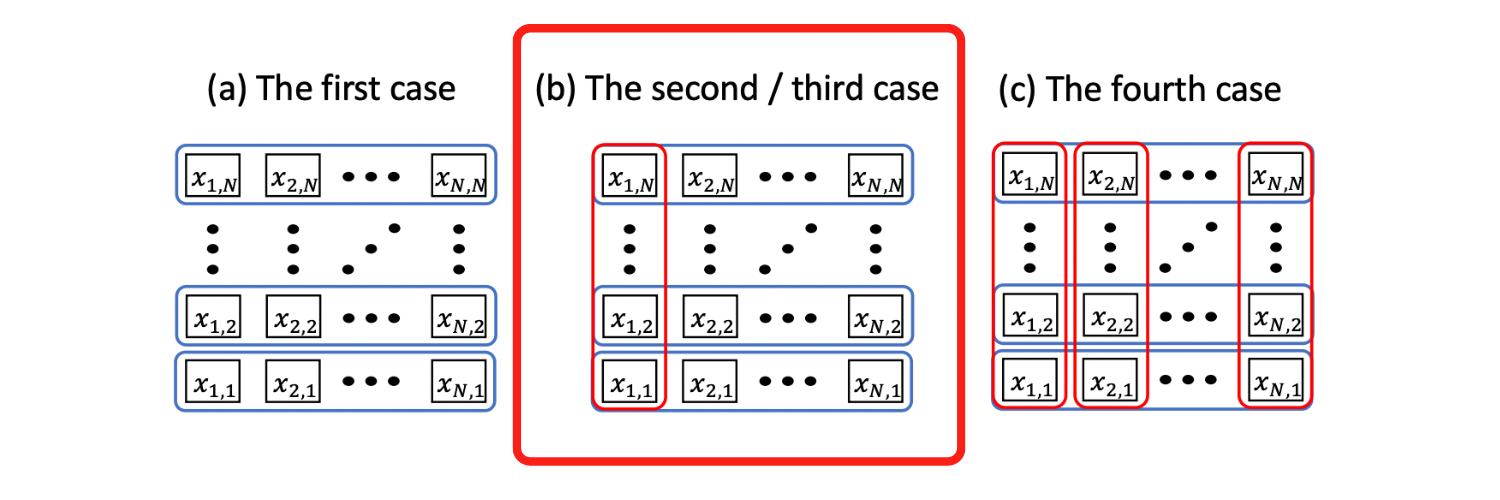

Image credits: **[Matsuo, A., Suzuki, Y., & Yamashita, S. (2020). Problem-specific parameterized quantum circuits of the VQE algorithm for optimization problems. arXiv preprint arXiv:2006.05643.](https://arxiv.org/pdf/2006.05643.pdf)**

## Designing for the second case - L shaped constraint with CNOT gates

We shall break down the protocol into a few steps and build up the routine for a 3 node graph. As mentioned above, we shall be taking into account not only the first line but also the second line of constraints to further reduce the subspace. To add in correlations among the qubits mapped to the variables (recall the mapping is column-major ordered), we will now create an entangled routine to complete the protocol.

Let us first create a PQC that satisfies both of the constraints $\sum_{p=1}^N x_{1,p}=1$ and $\sum_{v=1}^N x_{1,v}=1$. Recall, here $v$ refers to the vertex and $p$ represents its order in a prospective cycle. Building for a 3 node graph, let us first build the 'L' constraint circuit as shown in the paper!

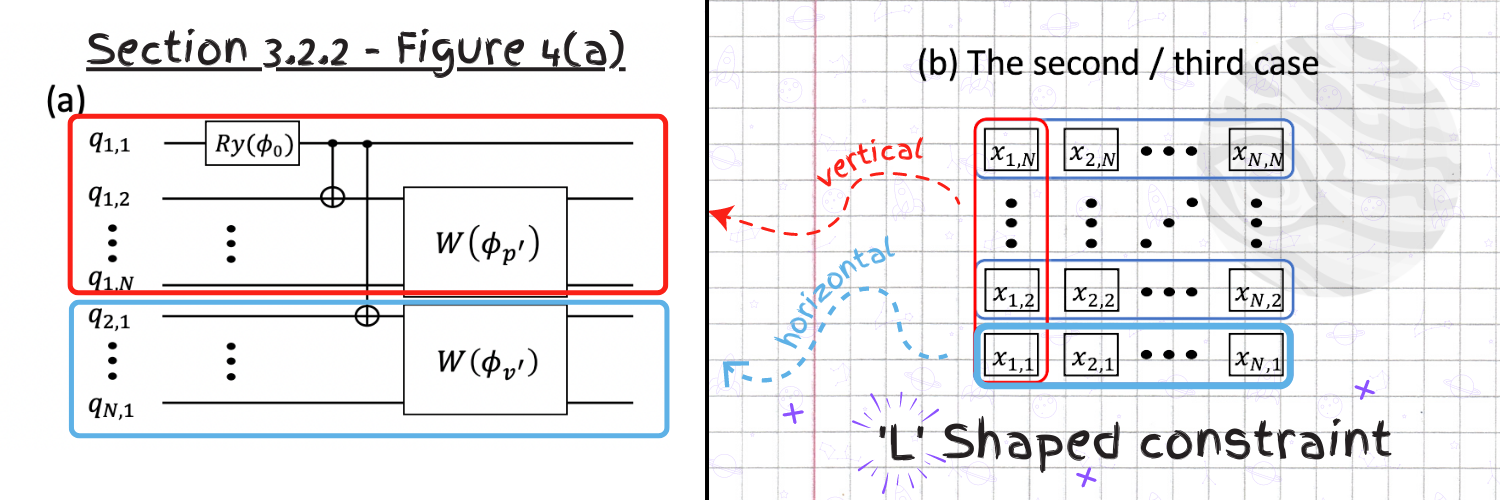

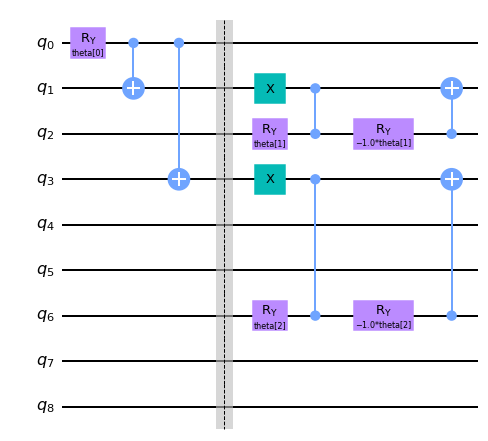

In [34]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector, QuantumCircuit

l_circuit = QuantumCircuit(n**2)
theta = ParameterVector('theta',length=(n-1)*n-1)

# L-Shaped Entangler
l_circuit.ry(theta[0],0)
l_circuit.cx(0,1)
l_circuit.cx(0,3)

l_circuit.barrier()

#W_phi_p
l_circuit.x(1)
l_circuit.ry(theta[1],2)
l_circuit.cz(1,2)
l_circuit.ry(-theta[1],2)
l_circuit.cx(2,1)

#W_phi_v
l_circuit.x(3)
l_circuit.ry(theta[2],6)
l_circuit.cz(3,6)
l_circuit.ry(-theta[2],6)
l_circuit.cx(6,3)

l_circuit.draw("mpl")


Next, now we need to **encode the remaining constraints** excluding the ones we applied. Since, the constraints for the remaining part are already determined, they can be read in a similar way as the previous problem by applying the corresponding $CNOT$ gates followed by the parametrized $W$ state gates on the qubits mapped variables as shown below!

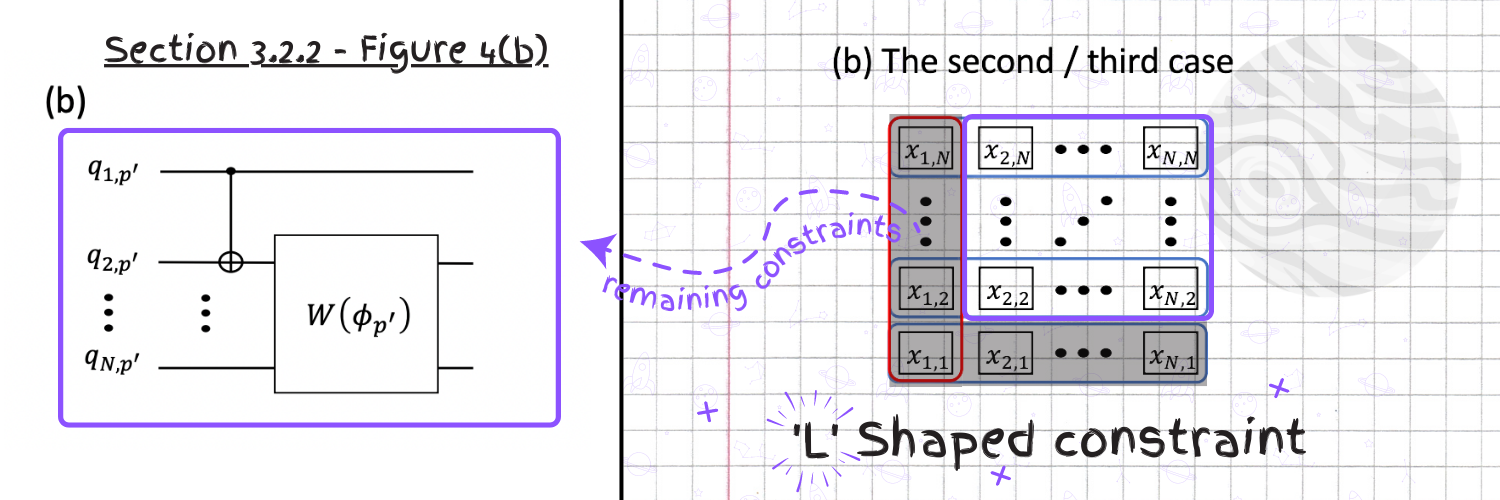

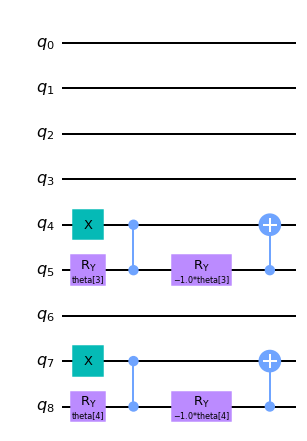

In [35]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector, QuantumCircuit

r_circuit = QuantumCircuit(n**2)
theta = ParameterVector('theta',length=(n-1)*n-1)

# Two blocks remaining for N = 3
# Block 1 ---------
r_circuit.x(4)
r_circuit.ry(theta[3],5)
r_circuit.cz(4,5)
r_circuit.ry(-theta[3],5)
r_circuit.cx(5,4)


# Block 2 ---------
r_circuit.x(7)
r_circuit.ry(theta[4],8)
r_circuit.cz(7,8)
r_circuit.ry(-theta[4],8)
r_circuit.cx(8,7)

r_circuit.draw("mpl")

One final step before we join the circuits is making the **bridge between L-shape and original entangler**. We shall construct it as follows:

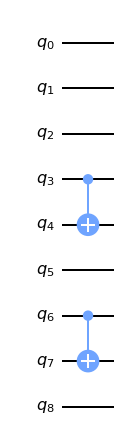

In [36]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector, QuantumCircuit

bridge_circuit = QuantumCircuit(n**2)
theta = ParameterVector('theta',length=(n-1)*n-1)

bridge_circuit.cx(3,4)
bridge_circuit.cx(6,7)

bridge_circuit.draw(output="mpl")

Now we proceed to join all the three circuits as shown in the figure below to complete the routine. We will run the constructed circuit using the RunVQE function which we created in the previous exercises to evaluate the result!

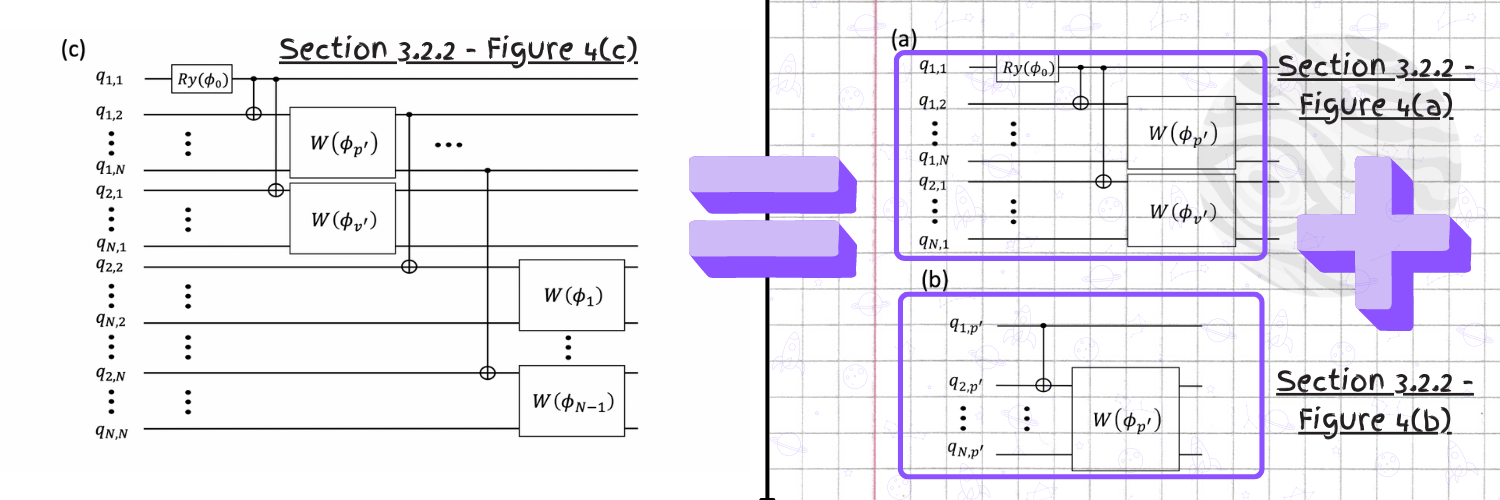

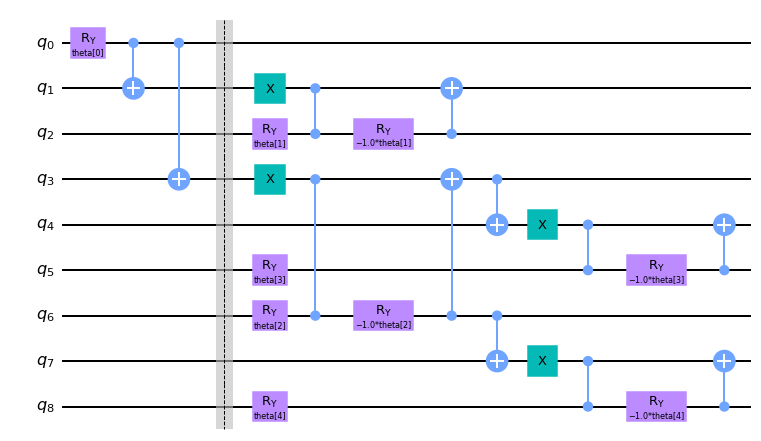

In [37]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector, QuantumCircuit

model_2 = QuantumCircuit(n**2)
theta = ParameterVector('theta',length=(n-1)*n-1)

model_2 = l_circuit.compose(bridge_circuit).compose(r_circuit)
model_2.draw("mpl")

Calling the RunVQE function to run the circuit for our graph with the following model:

In [38]:
%%time
# # #This is not a graded exercise. Run this cell when you have spare time. 
# Define optimizer
optimizer = SPSA()

# Define Initial point
np.random.seed(10)
init_2 = np.random.rand((n-1)*n-1) * 2 * np.pi

# Call RunVQE
with Session(service = service, backend = backend):
    result_m2, mean_m2 = RunVQE(Estimator(), model_2, optimizer, qubitOp, init=init_2)
print(result_m2, "\n")

{   'aux_operators_evaluated': None,
    'cost_function_evals': 200,
    'eigenvalue': -4750.997159699884,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa8441a2b50>,
    'optimal_parameters': {   ParameterVectorElement(theta[0]): 4.527852355263743,
                              ParameterVectorElement(theta[1]): -0.00049640021749807,
                              ParameterVectorElement(theta[2]): 4.710683482941784,
                              ParameterVectorElement(theta[3]): 4.713051906608456,
                              ParameterVectorElement(theta[4]): 3.14206670177236},
    'optimal_point': array([ 4.52785236e+00, -4.96400217e-04,  4.71068348e+00,  4.71305191e+00,
        3.14206670e+00]),
    'optimal_value': -4750.997159699884,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7fa8442ff070>,
    'optimizer_time': 1.1542949676513672} 

CPU times: user 1.13 s, sys: 24.2 ms

In [39]:
# #This is not a graded exercise. Run this cell when you have spsare time. 
optimal_m2 = result_m2.optimal_circuit.measure_all(inplace=False)

In [40]:
%%time
# # #This is not a graded exercise. Run this cell when you have spsare time. 
# Compute values
with Session(service=service, backend=backend):
    energy_m2, sampler_result_m2, result_val_m2, result_m2_bitstring = BestBitstring(result=result_m2, optimal_circuit=optimal_m2)
print("Optimal bitstring = ", result_m2_bitstring[7:])

Optimal bitstring =  [0 1 0 1 0 0 0 0 1]
CPU times: user 31.6 ms, sys: 0 ns, total: 31.6 ms
Wall time: 1.11 s


-------------------
Energy: -4750.997159699884
Tsp objective: 130.00284030011608
Feasibility: True
Solution Vector: [1, 0, 2]
Solution Objective: 130.0
-------------------


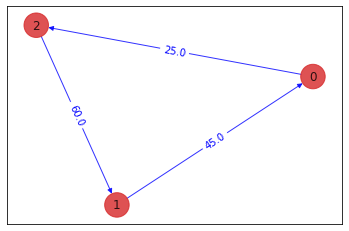

In [41]:
# # #This is not a graded exercise. Run this cell when you have spsare time. 
# Compute cost of the obtained result and display result
TSPCost(energy=energy_m2, result_bitstring=result_m2_bitstring[7:], adj_matrix=adj_matrix)

## Plot Convergence

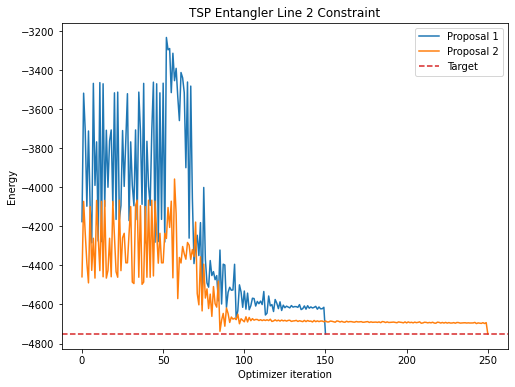

In [42]:
# Plot convergence
PlotGraph(mean = [mean,mean_m2], ideal = ideal)

We can see the faster convergence with the newer model! We shall now look at the fourth case extending on the implementation of the second case here. We shall be skipping the third case in the interest of keeping the lab length in check, but please feel free to check out the "parameter sharing" approach of constructing the PQC shared in the paper that aims to keep the circuit depth in check.

## Designing for the fourth case - specific PQC satisfying all constraints

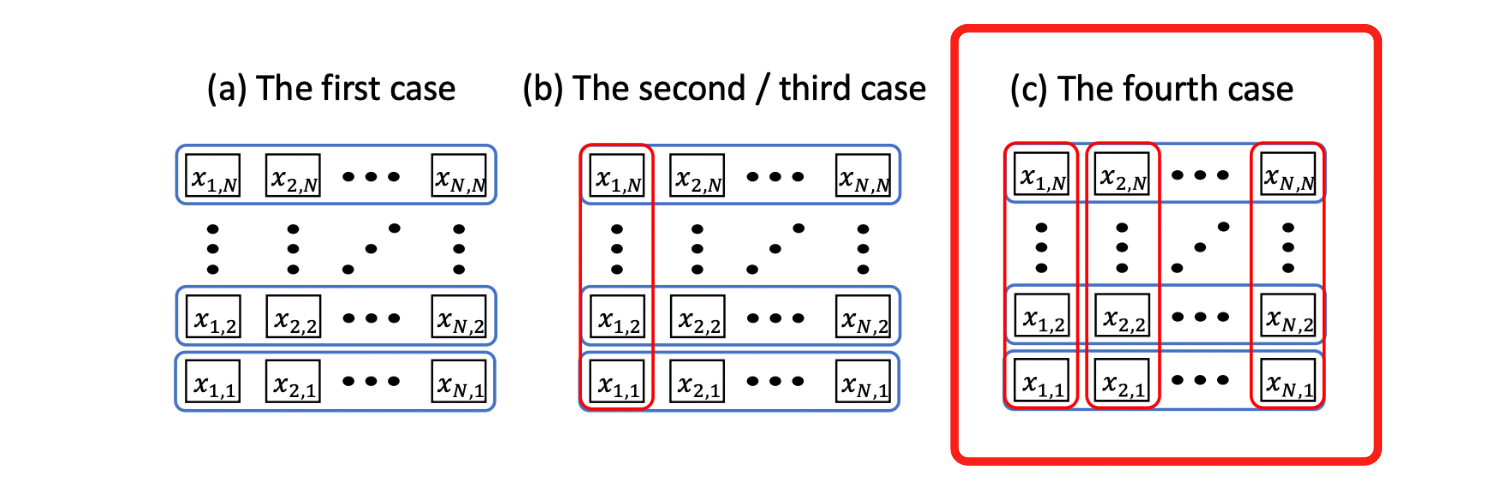

Image credits: **[Matsuo, A., Suzuki, Y., & Yamashita, S. (2020). Problem-specific parameterized quantum circuits of the VQE algorithm for optimization problems. arXiv preprint arXiv:2006.05643.](https://arxiv.org/pdf/2006.05643.pdf)**

Now let us consider the final case for the problem. For the fourth PQC, we consider all constraints to completely exclude the infeasible answers in the above image. Thus, the set of the bases of the quantum states includes **only feasible answers**. We shall now work on an intuition as to how to exclude all the infeasible results. If we see the 2D grid above, based on the constraints we define, the feasible answers can be interpreted in the form of permutation matrices.

### Permutation matrix

A permutation matrix is a sqaure matrix that is made up of only 1s and 0s and each row and column have exactly one 1 only. You may know the matrix $I$, which is called the identity matrix. It is a special case of permutation matrices.

Now that we know the definition of a permutation matrix, we can count the number of feasible answers that exist. If `n` = 2, there are 2 feasible solutions. Below you can check out what these matrices are.

$$
\begin{bmatrix}
1 & 0\\ 
0 & 1
\end{bmatrix}
,
\begin{bmatrix}
0 & 1\\ 
1 & 0
\end{bmatrix}
$$

Reflecting these two feasible answers, the circuit below is an example which satisfies all the constraints when `n` equals 2.

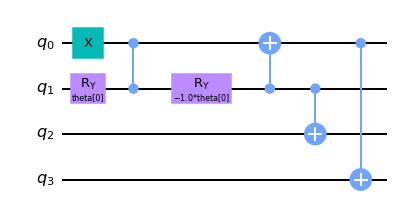

In [43]:
n = 2

perm_circuit = QuantumCircuit(n**2)
theta = ParameterVector('theta',length=(n-1)*n-1)

perm_circuit.x(0)

perm_circuit.ry(theta[0],1)
perm_circuit.cz(0,1)
perm_circuit.ry(-theta[0],1)
perm_circuit.cx(1,0)

perm_circuit.cx(1,2)
perm_circuit.cx(0,3)

perm_circuit.draw("mpl")

Such a PQC for arbitrary $N$ can be constructed in a recursive manner. Because we know the circuit when `n` = 2, we can construct circuits for the cases $n = 3, 4, ... k$. Let's make the $k \times k$ permutation matrices from the $(k-1) \times (k-1)$ ones.

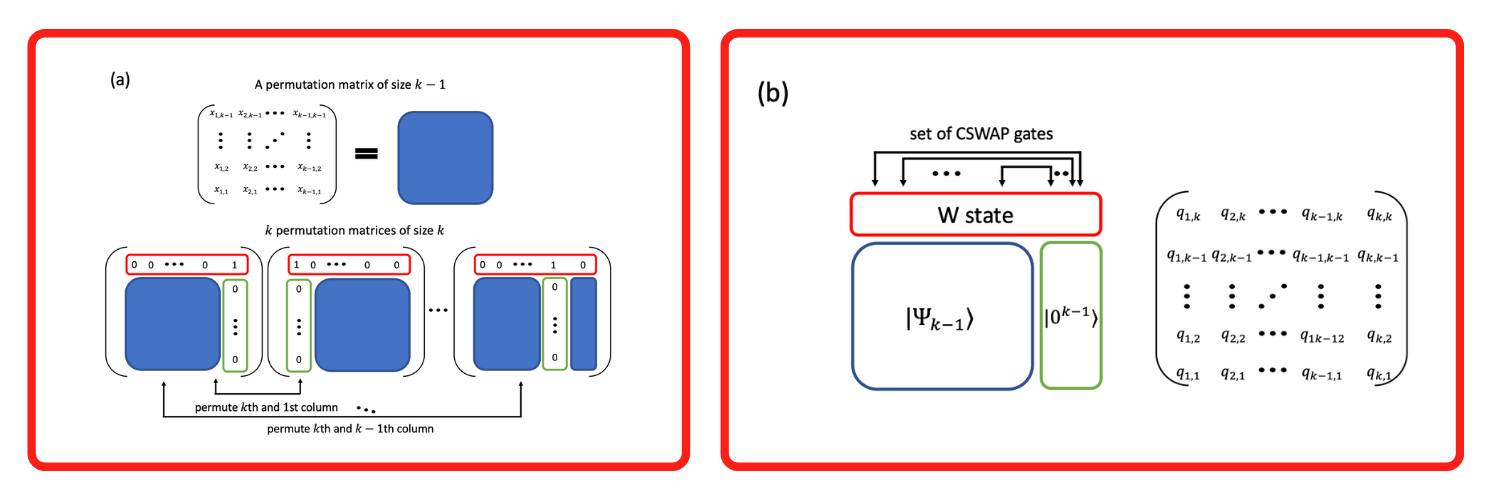

Image credits: **[Matsuo, A., Suzuki, Y., & Yamashita, S. (2020). Problem-specific parameterized quantum circuits of the VQE algorithm for optimization problems. arXiv preprint arXiv:2006.05643.](https://arxiv.org/pdf/2006.05643.pdf)**

1. Add one row and column which are filled with only zero.
2. At the top right, replace 0 to 1.
3. Exchange the last column with each column to make a set of permutation matrices.

As the steps above, we can create the desired quantum states as follows:

1. Prepare the initialized 2k - 1 qubits, labeled as $q_{k, p'}, p'= 1 ... k-1$ and $q_{v, k}, v= 1 ... k$.
2. Apply a parameterized W state gate to the set of qubits, {$q_{v, k}|v=1 ... k$}.
3. Apply {$CSWAP_{q_{v',k}, q_{k,p'}, q_{v',p'}}|p'=1 ... k-1$} for all $v'= 1 ... k-1$.

Let's start on the previous circuit while adding 5 more qubits. Note that CNOT gates' position is a little different because now $q_2$ in the circuit means $q_{3,1}$.

<a id="exercise8"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 8:</b> 
    
**Build up the `model_3` circuit for a 3 node graph problem** to accommodate all the constraints of the problem as shown **[in the paper](https://arxiv.org/pdf/2006.05643.pdf)**. We shall use the previous helper functions to run our problem.


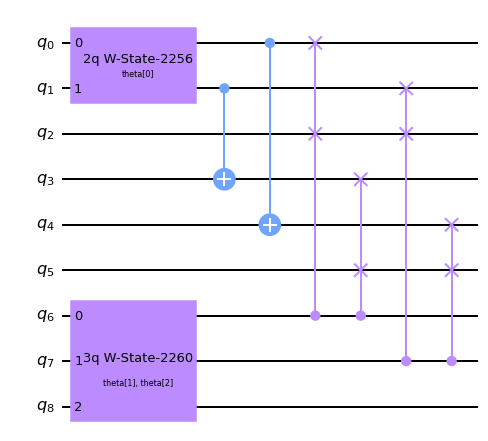

In [44]:
n = 3
model_3 = QuantumCircuit(n**2)
theta = ParameterVector('theta',length=(n-1)*n//2)

# Build a circuit when n is 2

# submatrix is [[q0,q1],[q3,a4]]
sub_circ = w_state(2).assign_parameters(theta[:1])
model_3.append(sub_circ, [0,1])
model_3.cx(1,3)
model_3.cx(0,4)

# Apply a parameterized W state gate

# row is [q6,q7,q8]
sub_circ = w_state(3).assign_parameters(theta[1:3])
model_3.append(sub_circ, [6,7,8])

# Apply 4 CSWAP gates

# if W-state qubit is 1, swap last column of 0's under it
model_3.cswap(6, 2, 0)
model_3.cswap(6, 5, 3)
model_3.cswap(7, 2, 1)
model_3.cswap(7, 5, 4)

model_3.draw("mpl")

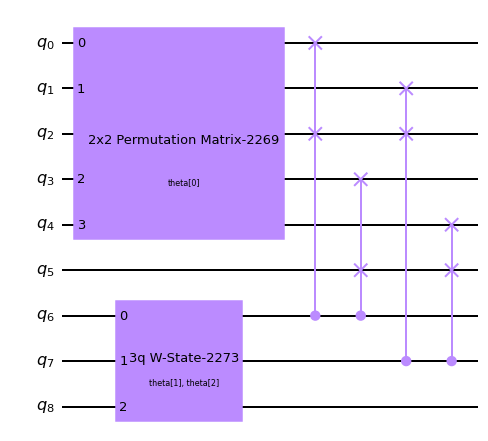

In [45]:
# Generalising the above to arbitrary n by n matrix
def perm_matrix(n):
    """Quanutum circuit to prepare a superposition of all representative n by n permutation matrices"""
    circuit = QuantumCircuit(n**2, name=f"{n}x{n} Permutation Matrix")
    theta = ParameterVector('theta', length=(n-1)*n//2)
    
    if n<2:
        raise ValueError(f"No {n}x{n} permutation matrix")
    elif n==2:
        # base 2x2 permutation matrix
        sub_circ = w_state(2).assign_parameters(theta)
        circuit.append(sub_circ, [0,1])
        circuit.cx(1,2)
        circuit.cx(0,3)
    else:
        # recursively prepare (n-1)**2 permutation matrix
        sub_circ = perm_matrix(n-1).assign_parameters(theta[:-(n-1)])
        sub_qubits = list(range(n*(n-1)))
        del sub_qubits[n-1::n] # [0...n-2,n...2n-2,...]
        circuit.append(sub_circ, sub_qubits)
        # W state of last row
        last_row = range(n**2-n, n**2) # last row index
        sub_circ = w_state(n).assign_parameters(theta[-(n-1):])
        circuit.append(sub_circ, last_row)
        # permute last column (based on last row)
        last_col = range(n-1, n**2-1, n) # last col index
        for i, lr in enumerate(last_row[:-1]):
            for lc in last_col:
                circuit.cswap(lr, lc, lc-(n-1)+i)
        
    return circuit
        
perm_matrix(3).draw(output="mpl")

The circuit above represents exactly the superposition of bases of 6 feasible answers. Now we shall call our helper function `RunVQE` to execute this routine

In [46]:
%%time
# Define optimizer
from qiskit.primitives import Estimator
optimizer = SPSA()

# Define Initial point
np.random.seed(10)
init_3 = np.random.rand((n-1)*n//2) * 2 * np.pi

#### Enter your code below ####

# Call RunVQE. Do not pass in options
with Session(service = service, backend = backend):
    result_m3, mean_m3 = RunVQE(Estimator(), model_3, optimizer, qubitOp, init_3)
    
#### Enter your code above ####

CPU times: user 1.31 s, sys: 32 ms, total: 1.34 s
Wall time: 1.49 s


<a id="Error"></a>
<div class="alert alert-block alert-info">
    
<b>Note on:  `AttributeError: 'Nonetype' object has no attribute values` :</b>   
    
When the cell is initially run, you may encounter this error message. If this is the case, please run the cell once again to ensure a successful convergence.

In [47]:
optimal_m3 = result_m3.optimal_circuit.measure_all(inplace=False) 

In [48]:
%%time
# Compute values
with Session(service=service, backend=backend):
    energy_m3, sampler_result_m3, result_val_m3, result_m3_bitstring = BestBitstring(result=result_m3, optimal_circuit=optimal_m3)
print("Optimal bitstring = ", result_m3_bitstring[7:])

Optimal bitstring =  [0 0 1 1 0 0 0 1 0]
CPU times: user 29.6 ms, sys: 35 µs, total: 29.6 ms
Wall time: 1.07 s


In [49]:
from qc_grader.challenges.fall_2022 import grade_lab3_ex8

grade_lab3_ex8(model_3, result_m3) # Expected result type - model_3: QuantumCircuit, result_m3: VQEResult

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


-------------------
Energy: -4751.000000000002
Tsp objective: 129.99999999999818
Feasibility: True
Solution Vector: [1, 2, 0]
Solution Objective: 130.0
-------------------


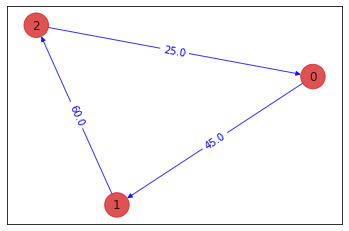

In [50]:
# Compute cost of the obtained result and display result
TSPCost(energy = energy_m3, result_bitstring = result_m3_bitstring[7:], adj_matrix = adj_matrix)

## Plot Convergence

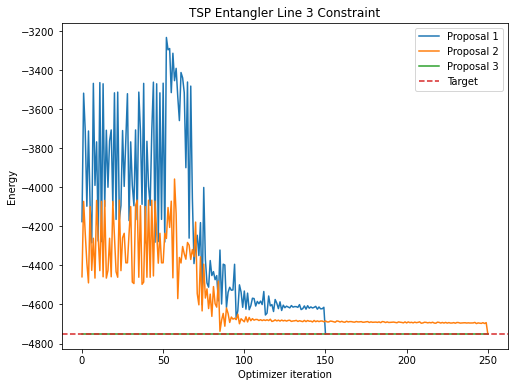

In [51]:
# Plot convergence
# PlotGraph(mean = [mean,mean_m3], ideal = ideal)
# Plot all three if you have run the L-shaped optional cell
PlotGraph(mean = [mean,mean_m2,mean_m3], ideal = ideal)

You will see a flat lined result close to the ideal result with an ideal simulator because it contains essentially only the feasible solution subspace which converges very fast in an ideal scenario.

<a id="Error"></a>
<div class="alert alert-block alert-info">
<h2> Crew log - All three constraint graphs </h2>
    
Here is an image is of a pre-run routine for all three approaches and their convergence characteristics in a single plot including the optional section run!
    
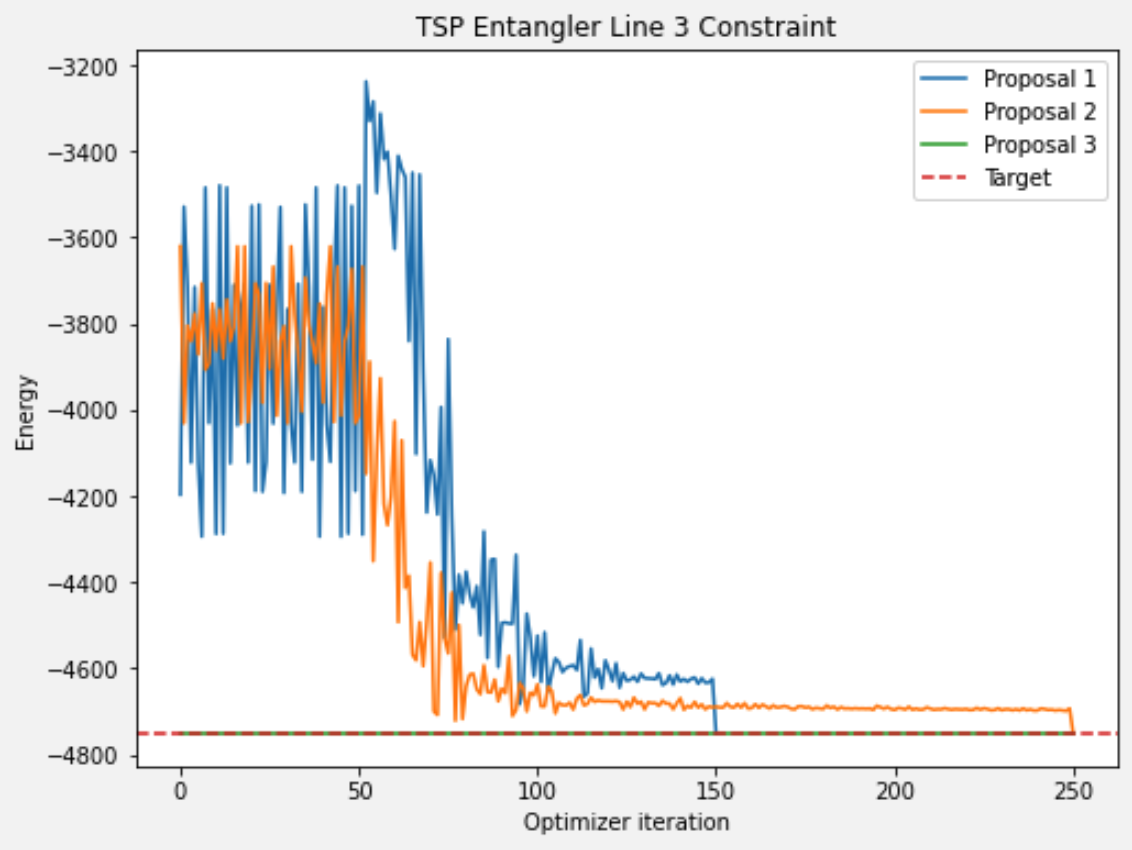
    
    

**Remember our example for a 4 node graph which failed to converge?** Now it's time to give it another go! Formulate a PQC for a 4 node graph in order to attempt a convergence for a given 4 node graph!

<a id="exercise9"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 9:</b> 
    
**Find a TSP solution for a 4 node graph problem** using any of the methods above. Please submit your `VQEResult` using Qiskit Runtime and `numpy.ndarray` bitstring answer. This is the real final exercise for lab 3. Enjoy!

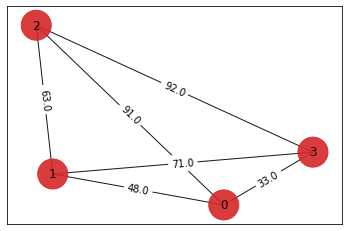

In [52]:
### DO NOT CHANGE BELOW

n = 4
num_qubits = n**2

# the target graph
tsp = Tsp.create_random_instance(n, seed=123)

colors = ["tab:red" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]

draw_graph(tsp.graph, colors, pos)

### DO NOT CHANGE ABOVE

In [53]:
#### Enter your code below ####

qp = tsp.to_quadratic_program()
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp_4, _ = qubo.to_ising()

#### Enter your code above ####

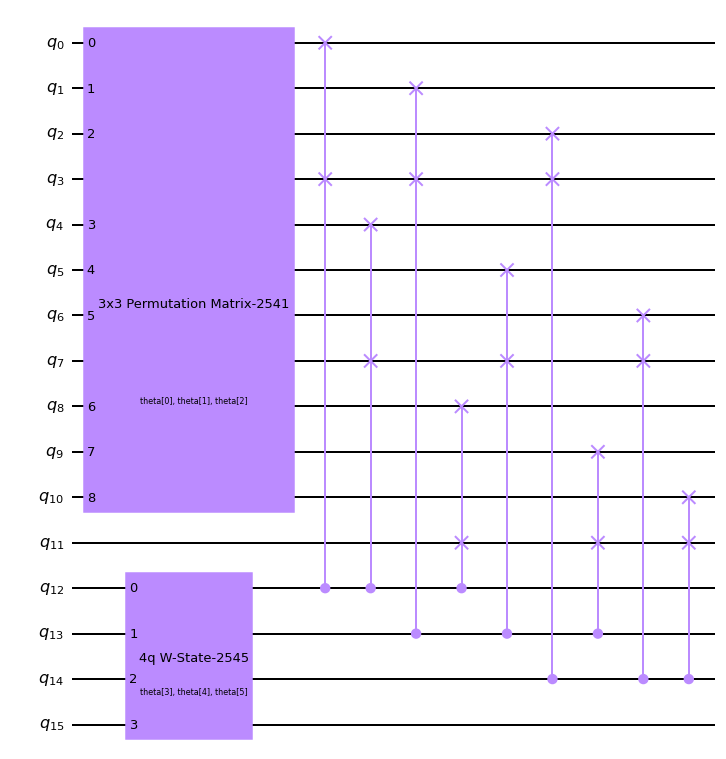

In [54]:
model = perm_matrix(n)

model.draw(output="mpl")

In [55]:
%%time
from qiskit.utils import algorithm_globals
from qiskit.primitives import Estimator
algorithm_globals.random_seed = 1024

# Define optimizer
optimizer = SPSA(maxiter=100)

# Define Initial point
np.random.seed(10)
init = np.random.rand((n-1)*n//2) * 2 * np.pi

# Define backend
backend = service.backends(simulator=True)[0]

# Call RunVQE. Do not pass in options
with Session(service = service, backend = backend):
    result_4, mean = RunVQE(Estimator(), model, optimizer, qubitOp_4, init=init)
    
# Print result
print(result_4)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 200,
    'eigenvalue': -51519.99981699653,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fa844074d30>,
    'optimal_parameters': {   ParameterVectorElement(theta[2]): 1.572015226117477,
                              ParameterVectorElement(theta[1]): 1.969067214793429,
                              ParameterVectorElement(theta[0]): 6.282792339574749,
                              ParameterVectorElement(theta[3]): 1.5721265678673573,
                              ParameterVectorElement(theta[4]): 4.683137339143627,
                              ParameterVectorElement(theta[5]): 1.5720577136833556},
    'optimal_point': array([6.28279234, 1.96906721, 1.57201523, 1.57212657, 4.68313734,
       1.57205771]),
    'optimal_value': -51519.99981699653,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7fa89fe063d0>,
    'optim

<a id="Error"></a>
<div class="alert alert-block alert-info">
    
<b>Note on:  `AttributeError: 'Nonetype' object has no attribute values` :</b>   
    
When the cell is initially run, you may encounter this error message. If this is the case, please run the cell once again to ensure a successful convergence.

In [56]:
optimal = result_4.optimal_circuit.measure_all(inplace=False)

In [57]:
%%time
# Compute values
with Session(service=service, backend=backend):
    energy, sampler_result, result_val, bitstring = BestBitstring(result=result_4, optimal_circuit=optimal)
print("Optimal bitstring = ", bitstring)

Optimal bitstring =  [1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1]
CPU times: user 27.6 ms, sys: 1.28 ms, total: 28.9 ms
Wall time: 1.36 s


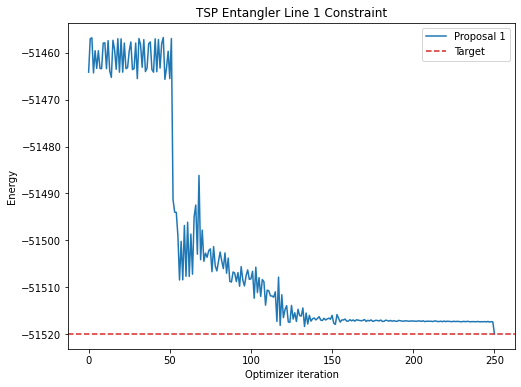

In [58]:
# Plot convergence
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp_4)
energy_numpy = result.eigenvalue.real

PlotGraph(mean = [mean], ideal = energy_numpy)

In [59]:
from qc_grader.challenges.fall_2022 import grade_lab3_ex9

grade_lab3_ex9(result_4, bitstring)

Submitting your answer. Please wait...

Congratulations 🎉! Your answer is correct.
You've successfully carved a clear path for your slingshot by targeting and collecting
certain orbiting objects with your drone.

You are almost ready to perform your slingshot. As you move your starship into position,
you wonder curiously about the other you out there.

Have they ceased to exist now that you haven't followed their path by selecting this planet?
Do they somehow exist in an alternate reality?

You can never know.

Nonetheless, you look out the window at the planets you didn't select, and whisper an aching,
heartfelt, "Thank you."
        


<a id="Optional Section"></a>

<div class="alert alert-block alert-success">
    
<b>Optional Section - ZNE with Qiskit Runtime </b>

**Congratulations on completing the exercises for Lab 3!** You may proceed to the next lab to continue on with the challenge! This is an **optional section** on showcasing how you can explore using and defining a **Digital ZNE** (in beta) routine on Qiskit runtime. This section is completely optional and purely for your curiosity with this new feature so feel free to explore and enjoy!
    
</div> 

# Applying Zero noise extrapolation (ZNE) using resilience levels (Beta)

We shall now explore the effect of **Zero Noise Extrapolation (ZNE)** on our routine. Recall in Lab 1 we explored that error mitigation strategies on runtime can be switched on when specifying the resilience level and higher levels generate more accurate results, at the expense of longer processing times.. Here we shall now specify a noise model and resilience levels to play around with ZNE. 

Please note: **This feature is still in beta** and results might not be as expected. The module is in continuous development scheduled for stable release in the future so feel free to experiment around with this routine!

We shall use the `FakeGuadalupe` backend to simulate our noisy system. Setting the options for a baseline run:

In [60]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Options, Session

# # Initialize service and backend
# #QiskitRuntimeService.save_account(channel='ibm_quantum', token='my_token', overwrite=True) #uncomment if you need to save your account again
service = QiskitRuntimeService(channel="ibm_quantum")

# # Set simulator
backend = service.backends(simulator=True)[0]
# print(backend)

In [61]:
from qiskit.providers.fake_provider import FakeGuadalupe
from qiskit_aer.noise import NoiseModel

fake_backend = FakeGuadalupe()
noise_model = NoiseModel.from_backend(fake_backend)

options = Options(
    simulator={
        "noise_model": noise_model,
        "seed_simulator": 42,
    },
    resilience_level=0  
)

Learning problem 3 Node graph: 
Ideal energy: -51520.0


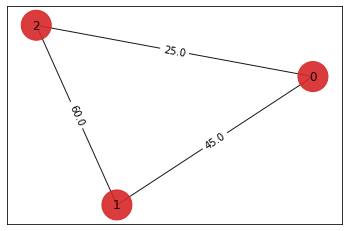

In [62]:
# Define 3 Node graph for our learning exercises
n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=250)

adj_matrix = nx.to_numpy_matrix(tsp.graph)

colors = ["tab:red" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]

print("Learning problem 3 Node graph: ")
draw_graph(tsp.graph, colors, pos)

# Define quadratic program for 4 node graph
qp = tsp.to_quadratic_program()

# Define Ising operator for 3 Node graph
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()

# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

ideal = result.eigenvalue.real
print(f"Ideal energy: {energy_numpy}")

## Noisy result
Now to get a baseline result, we shall run all our models we made above with a noisy backend. Here in the run options above, we shall specify the noise model and noise parameters to be passed on to our simulator backend. We shall be using 'FakeGuadalupe' as our backend. 

**Do note, this can take well over 15 minutes to run** so feel free to take some rest and stretch your legs as this is being processed!

In [63]:
%%time
optimizer = SPSA(maxiter= 50)
init =  np.random.rand((n-1)*n) * 2 * np.pi
model_1 = tsp_entangler(3)
with Session(service = service, backend = backend):
    print("Running model 1......")
    result_n, mean_n = RunVQE(Estimator(options=options), model_1, optimizer, qubitOp, init=init)
    print("Model 1 simulation complete")

Running model 1......
Model 1 simulation complete
CPU times: user 24.4 s, sys: 147 ms, total: 24.6 s
Wall time: 7min 22s


In [64]:
%%time  
with Session(service = service, backend = backend):    
    print("Running model 2......")
    result_m2_n, mean_m2_n = RunVQE(Estimator(options=options), model_2, optimizer, qubitOp, init=init_2)
    print("Model 2 simulation complete")

Running model 2......
Model 2 simulation complete
CPU times: user 24.4 s, sys: 155 ms, total: 24.6 s
Wall time: 6min


In [65]:
%%time
n=3
init_3 = np.random.rand((n-1)*n//2) * 2 * np.pi
with Session(service = service, backend = backend):    
    print("Running model 3......")
    result_m3_n, mean_m3_n = RunVQE(Estimator(options=options), model_3, optimizer, qubitOp, init=init_3)
    print("Model 3 simulation complete")

Running model 3......
Model 3 simulation complete
CPU times: user 23.8 s, sys: 153 ms, total: 24 s
Wall time: 7min 16s


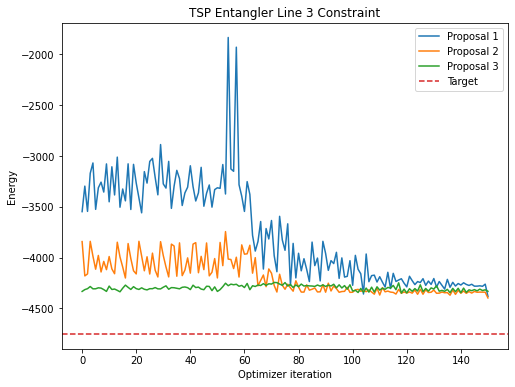

In [66]:
# Plot convergence
PlotGraph(mean = [mean_n,mean_m2_n,mean_m3_n], ideal = ideal)

Notice the result graphs are no longer converging to the ideal point as before due to the noise model applied. Now let's try to get it as close to the ideal value as possible by using Digital ZNE on Qiskit Runtime!

Advanced resilience options
----------------------------

(Adapted from: [Configure error mitigation release notes](https://github.com/Qiskit/qiskit-ibm-runtime/blob/main/docs/how_to/error-mitigation.rst))

The Estimator interface lets users seamlessly work with the variety of error mitigation methods to reduce error in expectation values of observables. Below is an example of leveraging Zero Noise Extrapolation by simply setting `resilience_level=2`. The default settings sample the expectation value at three noise factors, leading to a roughly **3x overhead** when employing this resilience level.

You can tune advanced options to configure your resilience strategy further. These methods can be used alongside resilience levels where you change the specific options of interest and let your previously set resilience level manage the rest. Please note, this is a beta release and as a part of the beta release of the resilience options, users will be able configure ZNE by using the following advanced options below: 

| Options  | Inputs  | Desctiption   | 
|:-------------|:-----------|:------|
| options.resilience.noise_amplifier(Optional[str]): Amplification Strategy   | `TwoQubitAmplifier` [Default]      | Amplifies noise of all two qubit gates by performing local gate folding.  | 
|  | `CxAmplifier`  | Amplifies noise of all CNOT gates by performing local gate folding.   |
|  | `LocalFoldingAmplifer`  | Amplifies noise of all gates by performing local gate folding.  | 
|  | `GlobalFoldingAmplifier`  | Amplifies noise of the input circuit by performing global folding of the entire input circuit.  | 
| options.resilience.noise_factors((Optional[Sequence[float]]) | `(1, 3, 5) [Default]`  | Noise amplification factors, where 1 represents the baseline noise. They all need to be greater than or equal to the baseline. | 
| options.resilience.extrapolator(Optional[str]) | `LinearExtrapolator` [Default] | Polynomial extrapolation of degree one.  |
| | `QuadraticExtrapolator` | Polynomial extrapolation of degree two and lower.  |
| | `CubicExtrapolator` | Polynomial extrapolation of degree three and lower. |
| | `QuarticExtrapolator` | Polynomial extrapolation of degree four and lower. |

## Setting options to run Digital ZNE on runtime

In [67]:
# Set options for Digital ZNE routine
options = Options(
    simulator={
        "noise_model": noise_model,
        "seed_simulator": 42,
    }, 
)

# Settings to set noise_factors, noise_amplifier and extrapolator
options.resilience.noise_factors = (1, 2, 3, 4) # Set noise_factors 
options.resilience.noise_amplifer = 'CxAmplifer' # Set noise_amplifiers
options.resilience.extrapolator = 'QuadraticExtrapolator' # Set noise_extrapolators

In [68]:
%%time
optimizer = SPSA(maxiter= 10)
with Session(service = service, backend = backend):
    print("Running model 1......")
    result_zn, mean_zn = RunVQE(Estimator(options=options), model_1, optimizer, qubitOp, init=init)
    print("Model 1 simulation complete")
    
    print("Running model 2......")
    result_m2_zn, mean_m2_zn = RunVQE(Estimator(options=options), model_2, optimizer, qubitOp, init=init_2)
    print("Model 2 simulation complete")
    
    print("Running model 3......")
    result_m3_zn, mean_m3_zn = RunVQE(Estimator(options=options), model_3, optimizer, qubitOp, init=init_3)
    print("Model 3 simulation complete")

Running model 1......
Model 1 simulation complete
Running model 2......
Model 2 simulation complete
Running model 3......
Model 3 simulation complete
CPU times: user 19.4 s, sys: 133 ms, total: 19.5 s
Wall time: 11min 20s


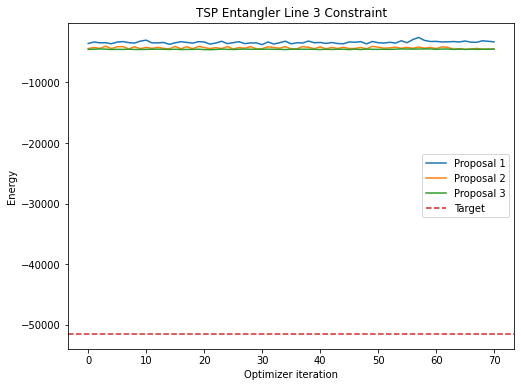

In [69]:
# Plot convergence
PlotGraph(mean = [mean_zn,mean_m2_zn,mean_m3_zn], ideal = energy_numpy)

### Experimental Results
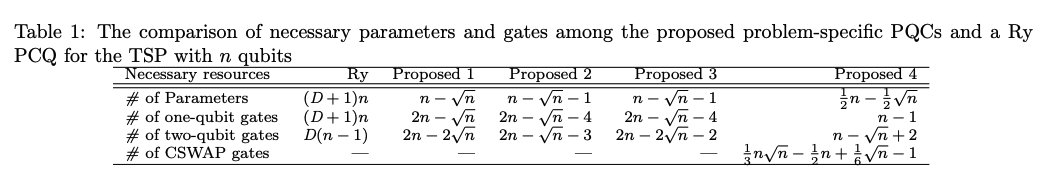

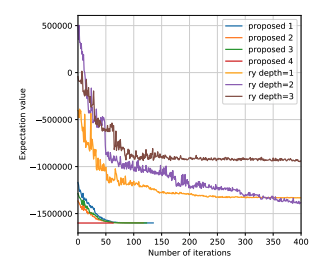

# References
- [1] **[Solving Combinatorial Optimziation Problems using QAOA](https://learn.qiskit.org/course/ch-applications/solving-combinatorial-optimization-problems-using-qaoa)**
- [2] **[Max-Cut and Traveling Salesman Problem](https://qiskit.org/documentation/optimization/tutorials/06_examples_max_cut_and_tsp.html)**
- [3] **[Quantum Bridge Analytics I: A Tutorial on Formulating and Using QUBO Models](https://arxiv.org/pdf/1811.11538.pdf)**
- [4] **[Matsuo, A., Suzuki, Y., & Yamashita, S. Problem-specific parameterized quantum circuits of the VQE algorithm for optimization problems. 2020.](https://arxiv.org/pdf/2006.05643.pdf)**
- [5] **[Configure error mitigation - release notes](https://github.com/Qiskit/qiskit-ibm-runtime/blob/main/docs/how_to/error-mitigation.rst)**


# Additional information

<b>Created by:</b> Astri Cornish, Dayeong Kang, Desiree Vogt-Lee, Vishal Bajpe, Yuri Kobayashi

<b>Advisor:</b> Takashi Imamichi, Atsushi Matsuo, Yudai Suzuki

<b>Creative assets by:</b> Radha Pyari Sandhir

Version: 1.1

In [70]:
from qiskit.tools.jupyter import *
%qiskit_version_table